### 1 Day Lookback KDE VaR Vectors

In [115]:
import scipy.stats as stats
import numpy as np
import pyodbc
import pandas as pd

cnxn_str = ("DRIVER={SQL ServeR};"
    "Server=E360-DB01;"
    "Database=Voltage;"
    "Trusted_Connection=yes;")
connsql = pyodbc.connect(cnxn_str)
cursql = connsql.cursor()

sql = """select *
           from dbo.get_returns_data('@p_as_of_date','@p_var_ticker',@l_years)
          order by prompt_month;"""

sql = sql.replace('@p_as_of_date', '11-OCT-2023')
sql = sql.replace('@l_years', '1')
sql = sql.replace('@p_var_ticker', 'PMI')

print (sql)

data = pd.read_sql_query(sql,connsql)
data

select *
           from dbo.get_returns_data('11-OCT-2023','PMI',1)
          order by prompt_month;


C:\Users\kjones\AppData\Local\Temp\ipykernel_45968\81048878.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(sql,connsql)


,var_ticker,prompt_month,hist_return
0,PMI,1,-0.00058
1,PMI,1,-0.04605
2,PMI,1,-0.09069
3,PMI,1,-0.01147
4,PMI,1,-0.01831
...,...,...,...
15295,PMI,60,-0.02194
15296,PMI,60,0.00000
15297,PMI,60,-0.00275
15298,PMI,60,0.00000


In [85]:
import pandas as pd
import pyodbc 
from scipy.stats import norm, gaussian_kde
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import scipy.stats as stats
import math
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

pd.options.display.float_format = '{:,.5f}'.format


cnxn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=e360-db01;'
    r'DATABASE=Voltage;'
    r'Trusted_Connection=yes;'
)


query = """
with hist_returns
  as (select  var_ticker, prompt_month, avg(hist_return) hist_return, avg(hist_vol) hist_vol 
          from [dbo].[get_scenario_hvar_returns_data]('11-OCT-2023') 
          where var_ticker = 'PMI'
            and hist_vol is not null
        group by  var_ticker, prompt_month
     ), implied_vols
  as (select  exchange_symbol
            , rank() over(partition by as_of_date, exchange_symbol order by tenor asc) prompt_month 
            , tenor, option_volatility implied_volatility
          from key_option_volatilities
         where exchange_symbol = 'PMI'
           and as_of_date = '11-OCT-2023'
     ), current_prices
  as (select exchange_code var_ticker, tenor
           , rank() over(partition by as_of_date, exchange_code order by tenor asc) prompt_month 
           , price
        from exchange_prices ep
       where as_of_date = '11-OCT-2023'
         and exchange_code = 'PMI'
         and tenor > getdate()
     )
    select hr.var_ticker, hr.prompt_month, hr.hist_return, hr.hist_vol, iv.implied_volatility, cp.price
      from hist_returns hr
     inner join implied_vols iv
        on  hr.prompt_month = iv.prompt_month
       and hr.var_ticker = iv.exchange_symbol
     inner join current_prices cp
        on hr.var_ticker = cp.var_ticker
       and hr.prompt_month = cp.prompt_month
       where hr.prompt_month <=60
    order by hr.prompt_month
"""



prices = pd.read_sql(query, cnxn)
prices

C:\Users\kjones\AppData\Local\Temp\ipykernel_45968\1862183713.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prices = pd.read_sql(query, cnxn)


,var_ticker,prompt_month,hist_return,hist_vol,implied_volatility,price
0,PMI,1,-0.00249,31.76139,55.10480,45.65000
1,PMI,2,-0.00139,41.13268,66.82570,53.50000
2,PMI,3,-0.00086,27.33316,80.94100,73.50000
3,PMI,4,-0.00016,24.14225,81.57180,67.20000
4,PMI,5,0.00075,19.54100,53.47100,49.05000
5,PMI,6,0.00095,13.42582,42.43770,46.10000
6,PMI,7,0.00087,11.39299,43.06000,47.25000
7,PMI,8,0.00066,11.30121,45.08390,48.75000
8,PMI,9,0.00081,11.45941,46.04340,67.85000
9,PMI,10,0.00067,12.07927,46.22930,59.65000


In [2]:
# data.hist_vol /= 100
# data.implied_volatility /= 100
# # data['implied_to_hist_ratio'] = data.implied_volatility / data.hist_vol
# # data

In [3]:
corr_query = """
select *
  from key_correlations
 where correlation_name = 'PMI vs PMI'
   and as_of_date = '11-OCT-2023'
"""

corr = pd.read_sql(corr_query, cnxn)
corr

C:\Users\kjones\AppData\Local\Temp\ipykernel_63892\100515942.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  corr = pd.read_sql(corr_query, cnxn)


,as_of_date,correlation_name,ticker_side1,ticker_side2,prompt_month_side1,prompt_month_side2,correlation_value
0,2023-10-11,PMI vs PMI,pmi,pmi,1.00000,1.00000,1.00000
1,2023-10-11,PMI vs PMI,pmi,pmi,1.00000,2.00000,0.58898
2,2023-10-11,PMI vs PMI,pmi,pmi,1.00000,3.00000,0.29078
3,2023-10-11,PMI vs PMI,pmi,pmi,1.00000,4.00000,-0.04797
4,2023-10-11,PMI vs PMI,pmi,pmi,1.00000,5.00000,-0.34864
...,...,...,...,...,...,...,...
5179,2023-10-11,PMI vs PMI,pmi,pmi,72.00000,68.00000,-0.64445
5180,2023-10-11,PMI vs PMI,pmi,pmi,72.00000,69.00000,-0.92591
5181,2023-10-11,PMI vs PMI,pmi,pmi,72.00000,70.00000,-0.55923
5182,2023-10-11,PMI vs PMI,pmi,pmi,72.00000,71.00000,0.03604


In [30]:
def evaluate_bandwidths(data, bandwidths, title):
    """Visualizes KDE for a range of bandwidths."""
    plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram")
    plt.title(title)
    for bw in bandwidths:
        kde = gaussian_kde(data, bw_method=bw)
        x_vals = np.linspace(min(data), max(data), 1000)
        plt.plot(x_vals, kde(x_vals), label=f"KDE (bw={bw})")
    plt.legend()
    plt.show()

In [32]:
for num in data.prompt_month.unique():
    print('Prompt Month', num, 'has', len(data[data.prompt_month == num]), 'observations.')

Prompt Month 1 has 255 observations.
Prompt Month 2 has 255 observations.
Prompt Month 3 has 255 observations.
Prompt Month 4 has 255 observations.
Prompt Month 5 has 255 observations.
Prompt Month 6 has 255 observations.
Prompt Month 7 has 255 observations.
Prompt Month 8 has 255 observations.
Prompt Month 9 has 255 observations.
Prompt Month 10 has 255 observations.
Prompt Month 11 has 255 observations.
Prompt Month 12 has 255 observations.
Prompt Month 13 has 255 observations.
Prompt Month 14 has 255 observations.
Prompt Month 15 has 255 observations.
Prompt Month 16 has 255 observations.
Prompt Month 17 has 255 observations.
Prompt Month 18 has 255 observations.
Prompt Month 19 has 255 observations.
Prompt Month 20 has 255 observations.
Prompt Month 21 has 255 observations.
Prompt Month 22 has 255 observations.
Prompt Month 23 has 255 observations.
Prompt Month 24 has 255 observations.
Prompt Month 25 has 255 observations.
Prompt Month 26 has 255 observations.
Prompt Month 27 has 2

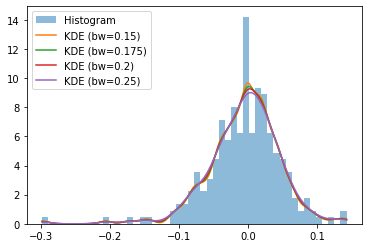

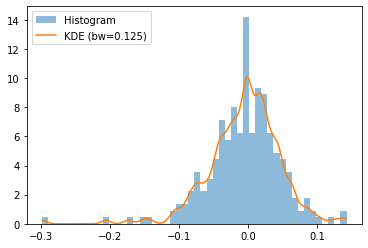

array([[-8.96436253e-03, -8.14335528e-02, -1.21611597e-02,
         1.44206182e-02, -1.85544356e-02, -4.91162498e-02,
        -3.28021810e-02, -1.97354595e-03,  3.91929794e-02,
         4.39029674e-03,  1.90585841e-02, -3.26323810e-02,
         5.53726664e-02, -3.92246069e-03,  1.26353820e-01,
        -2.85013197e-02,  4.70416882e-02, -2.82213843e-02,
         5.29391980e-03, -2.33850311e-02,  7.73999907e-03,
        -7.50658091e-02,  1.91821613e-02,  5.37191390e-02,
        -3.31063151e-03, -2.28994969e-02,  6.48570465e-02,
         1.64958557e-02, -1.68795777e-03, -4.93688955e-03,
         3.45901715e-02,  2.46757978e-02,  5.59525566e-02,
         2.63108792e-02,  6.86990472e-02,  4.97787589e-03,
         4.68768760e-02,  1.97703192e-02,  7.52024386e-02,
         2.34592147e-02, -4.57041284e-02, -6.73089891e-02,
        -8.28165941e-02,  1.91413761e-02, -2.18935760e-02,
        -1.61508525e-02,  1.37318073e-02, -7.39971741e-02,
        -9.03588030e-02, -8.89297392e-03,  4.52760086e-0

<class 'numpy.ndarray'>


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.00896,-0.08143,-0.01216,0.01442,-0.01855,-0.04912,-0.03280,-0.00197,0.03919,0.00439,...,0.06082,-0.10592,-0.02445,0.01599,-0.00227,-0.01804,-0.04362,-0.07991,0.03763,-0.01193


24.095251321792603


In [102]:
%timeit
bandwidths = [0.15, 0.175, 0.2, 0.25]  

def monte_carlo_simulation_adjusted(data, num_simulations=10, bandwidth=None):
    """Adjusted Monte Carlo simulation using pre-computed inverse KDE."""
    kde = plot_kde_against_histogram(data.hist_return, bandwidth=bandwidth)
    data_min, data_max = min(data.hist_return), max(data.hist_return)
    
    inverse_kde_interp = compute_inverse_kde(kde, data_min, data_max)
    
    u_vals = np.random.uniform(size=(1, num_simulations))
    simulated_prices = inverse_kde_interp(u_vals)
    
    # Adjust simulated prices to match the original data's mean and standard deviation
    simulated_prices = (simulated_prices - np.mean(simulated_prices)) / np.std(simulated_prices)
    simulated_prices = simulated_prices * np.std(data.hist_return) + np.mean(data.hist_return)
    display(simulated_prices)
    print(type(simulated_prices))
    
    return simulated_prices.tolist()

# for num in data.prompt_month.unique():
num=2
evaluate_bandwidths(data[data.prompt_month == num].hist_return,bandwidths)
start = time.time()
simulations = monte_carlo_simulation_adjusted(data[data.prompt_month == num], num_simulations=500, bandwidth=0.125)
end = time.time() 
display(pd.DataFrame(simulations))
print(end - start)
#     break

In [100]:
len(simulations[0])

252

(array([  3.,   0.,   5.,   0.,  38.,  56., 155., 178.,  54.,  11.]),
 array([-0.28237056, -0.24149812, -0.20062569, -0.15975325, -0.11888081,
        -0.07800837, -0.03713593,  0.00373651,  0.04460894,  0.08548138,
         0.12635382]),
 <BarContainer object of 10 artists>)

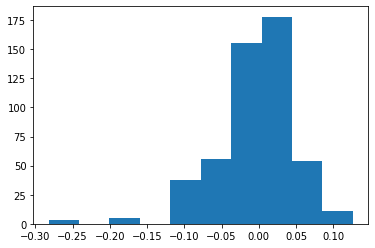

In [103]:
#Prompt Month 2
plt.hist(pd.DataFrame(simulations).T)

(array([  3.,  26., 104., 100.,  12.,   4.,   2.,   0.,   0.,   1.]),
 array([-0.16394698, -0.10993385, -0.05592071, -0.00190757,  0.05210557,
         0.1061187 ,  0.16013184,  0.21414498,  0.26815812,  0.32217125,
         0.37618439]),
 <BarContainer object of 10 artists>)

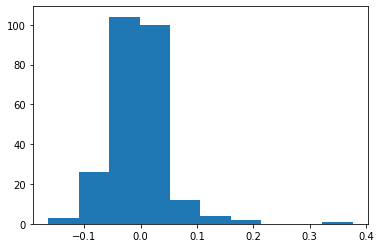

In [78]:
#Prompt Month 1
plt.hist(pd.DataFrame(simulations).T)

In [83]:
pd.DataFrame(simulations).T

,0
0,-0.06346
1,0.00847
2,0.04870
3,0.00441
4,-0.01484
...,...
247,0.08354
248,-0.07248
249,0.02496
250,0.11773


In [45]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Sample data (for the demonstration)
data_sample = {
    "var_ticker": ["PMI"]*5 + ["PMI"]*5,
    "prompt_month": [1]*5 + [2]*5,
    "hist_return": [-0.000578, -0.046053, -0.090692, -0.011473, -0.018310, 
                    -0.021941, 0.000000, -0.002747, 0.000000, -0.002611]
}
df = pd.DataFrame(data_sample)
display(df)

# def simulate_returns_for_prompt_month(data, num_simulations=100):
#     """Simulates returns for a given dataset using KDE."""
#     # Construct the KDE for the data
#     kde = gaussian_kde(data.hist_return)
    
#     # Generate random percentiles
#     u_vals = np.random.uniform(size=num_simulations)
    
#     # Use inverse KDE to get simulated returns
#     simulated_returns = kde.resample(size=num_simulations).flatten()
    
#     return simulated_returns

# Group by 'prompt_month' and apply the simulation function
grouped = df.groupby('prompt_month')
# simulated_data_by_prompt = grouped.apply(lambda group: simulate_returns_for_prompt_month(group, num_simulations=100))

# plt.hist(simulated_data_by_prompt)
simulated_data_by_prompt


,var_ticker,prompt_month,hist_return
0,PMI,1,-0.00058
1,PMI,1,-0.04605
2,PMI,1,-0.09069
3,PMI,1,-0.01147
4,PMI,1,-0.01831
5,PMI,2,-0.02194
6,PMI,2,0.00000
7,PMI,2,-0.00275
8,PMI,2,0.00000
9,PMI,2,-0.00261


prompt_month
1    [-0.0025795334943284932, -0.03399783426183808,...
2    [-0.003597138169459105, 0.010322555014492954, ...
dtype: object

In [41]:
(algo_end - algo_start)/60

21.50101881424586

In [50]:
len([-0.02892965419594874,
  0.30641594209830547,
  0.12279875628854096,
  0.015545499995117697,
  -0.055612955660946935,
  -0.011490912120838494,
  -0.07629967100014604,
  0.00020328551483669594,
  -0.01074535792943947,
  -0.012873465241126687])

10

In [56]:
np.array(df_simulations.iloc[0,0]).shape

(255, 10)

In [66]:
# for obj in grouped:

for obj in data.groupby('prompt_month'):
    display(obj)
    break

(1,
     var_ticker  prompt_month  hist_return
 0          PMI             1     -0.00058
 1          PMI             1     -0.04605
 2          PMI             1     -0.09069
 3          PMI             1     -0.01147
 4          PMI             1     -0.01831
 ..         ...           ...          ...
 250        PMI             1      0.03677
 251        PMI             1      0.11884
 252        PMI             1     -0.04752
 253        PMI             1     -0.00069
 254        PMI             1     -0.00779
 
 [255 rows x 3 columns])

In [104]:
data

,var_ticker,prompt_month,hist_return
0,PMI,1,-0.00058
1,PMI,1,-0.04605
2,PMI,1,-0.09069
3,PMI,1,-0.01147
4,PMI,1,-0.01831
...,...,...,...
15295,PMI,60,-0.02194
15296,PMI,60,0.00000
15297,PMI,60,-0.00275
15298,PMI,60,0.00000


prompt_month
1    [0.00967572926823132, 0.11560516187531307, 0.0...
2    [-0.019553211791097955, -0.04825328319404041, ...
3    [0.01620581611131774, -0.017196214384040058, 0...
4    [0.03178508836691432, -0.00866346097145854, 0....
5    [0.01797865693300843, -0.005773479354610567, 0...
Name: hist_return, dtype: object

0.040001630783081055


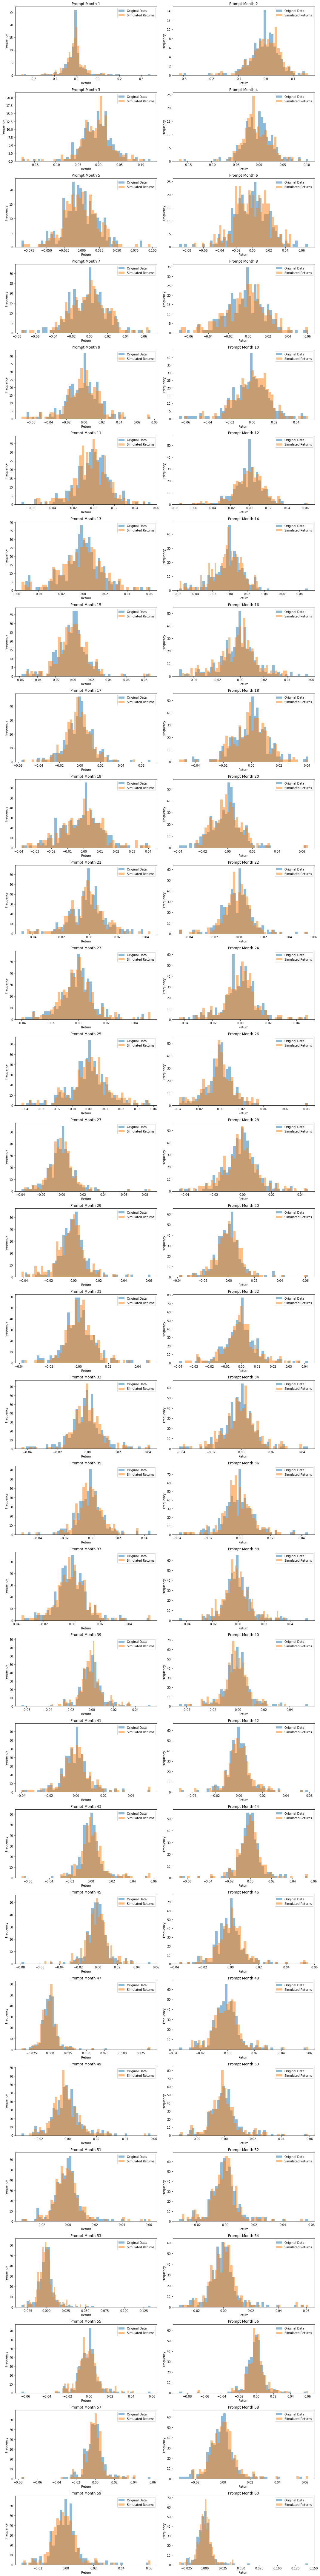

In [126]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.interpolate import interp1d
import math


def compute_kde_for_group(data, bandwidth=None):
    """Compute the KDE for a group."""
    return gaussian_kde(data, bw_method=bandwidth)

def sample_from_kde(kde, num_simulations=10):
    """Sample directly from a KDE."""
    return kde.resample(num_simulations).flatten()

def main_simulation_direct_sampling(data, num_simulations=10, bandwidth=0.2):
    # 1. Compute KDE for each group
    grouped = data.groupby('prompt_month')
    kdes_by_prompt = grouped['hist_return'].apply(lambda group: compute_kde_for_group(group, bandwidth))
    
    # 2. Sample directly from the KDE
    simulated_data_by_prompt = kdes_by_prompt.apply(lambda kde: sample_from_kde(kde, num_simulations))
    
    return simulated_data_by_prompt

# Execute the direct sampling simulation
num_simulations_small = 255
bandwidth = 0.2

start = time.time()
simulated_data_by_prompt_direct_sampling = main_simulation_direct_sampling(data, num_simulations_small, bandwidth)
end = time.time() 

display(simulated_data_by_prompt_direct_sampling.head())  # Displaying only the head for brevity)
print(end-start)

def visualize_original_vs_simulated_by_prompt(original_data, simulated_data):
    # Get unique prompts
    prompts = original_data['prompt_month'].unique()
    
    # Calculate the number of rows needed for 2 columns
    num_rows = int(np.ceil(len(prompts) / 2))
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    # For each prompt, plot original vs simulated
    for idx, prompt in enumerate(prompts):
        ax = axes[idx]
        
        # Extract data for this prompt
        prompt_original_data = original_data[original_data['prompt_month'] == prompt]['hist_return']
        prompt_simulated_data = simulated_data[prompt]
        
        # Plot original data histogram on the current axis
        ax.hist(prompt_original_data, bins=50, alpha=0.5, label="Original Data", density=True)
        
        # Overlay histogram of simulated returns on the current axis
        ax.hist(prompt_simulated_data, bins=50, alpha=0.5, label=f'Simulated Returns', density=True)
        
        ax.set_title(f'Prompt Month {prompt}')
        ax.set_xlabel('Return')
        ax.set_ylabel('Frequency')
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Execute the visualization for each prompt
visualize_original_vs_simulated_by_prompt(data, simulated_data_by_prompt_direct_sampling)

In [121]:
len(simulated_data_by_prompt_direct_sampling[1])

255

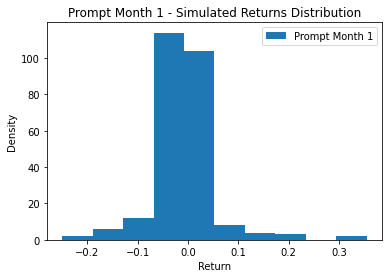

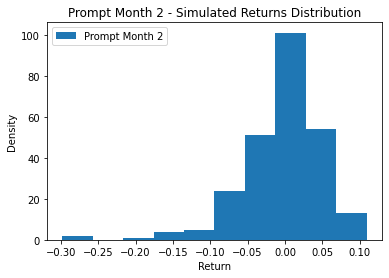

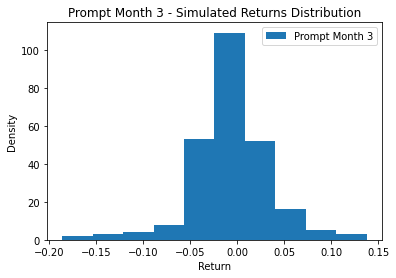

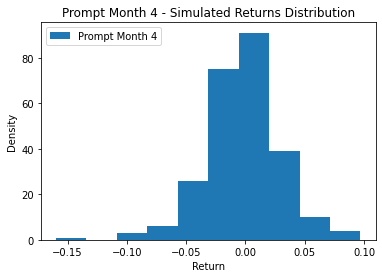

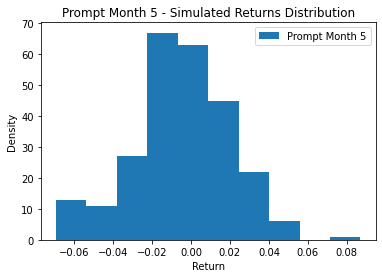

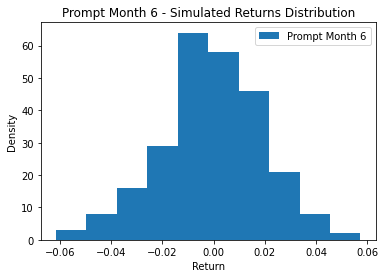

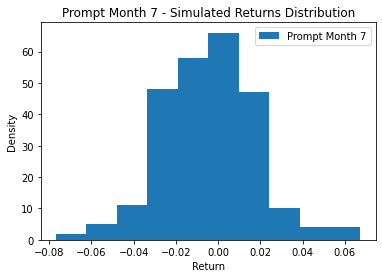

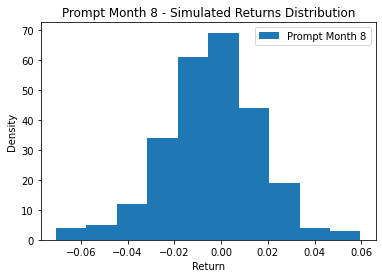

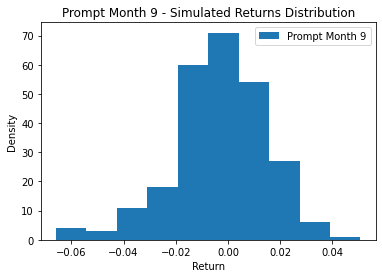

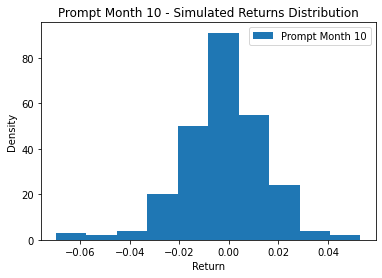

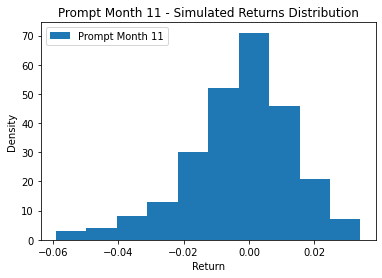

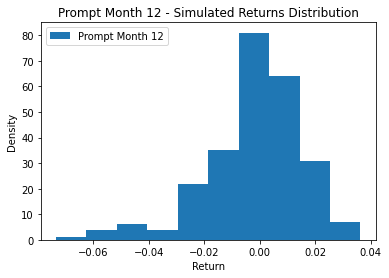

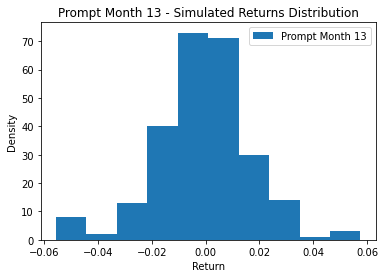

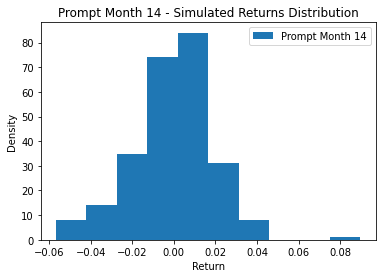

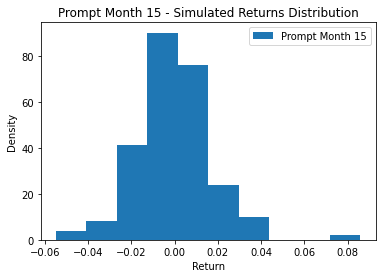

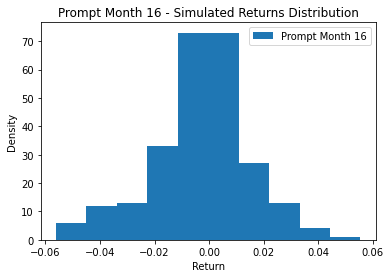

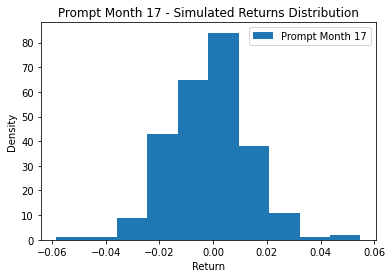

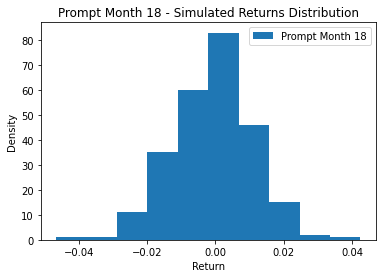

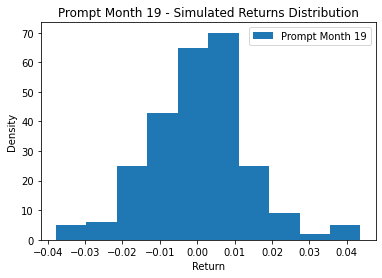

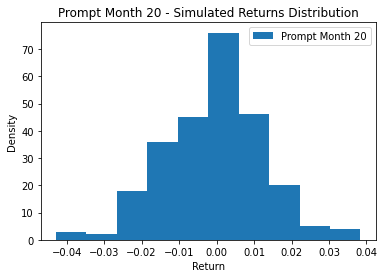

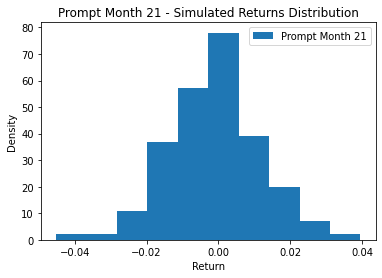

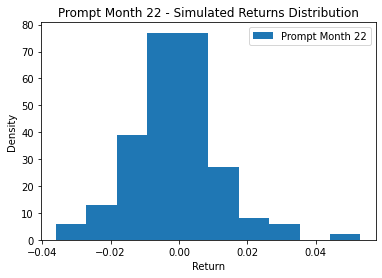

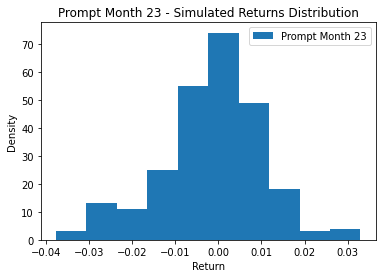

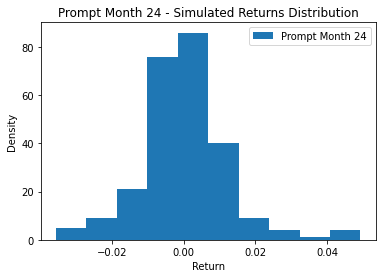

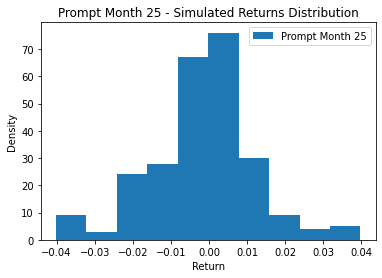

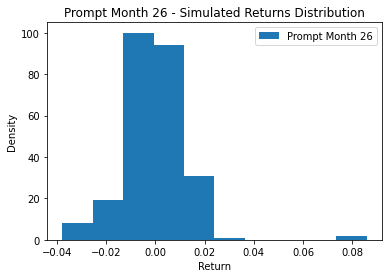

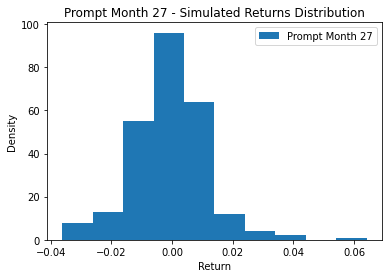

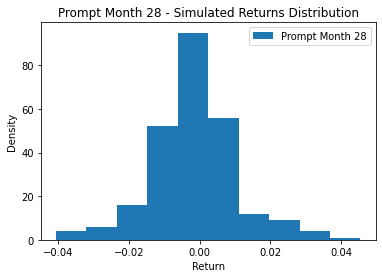

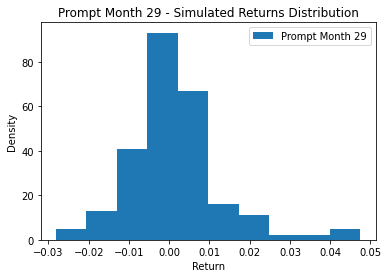

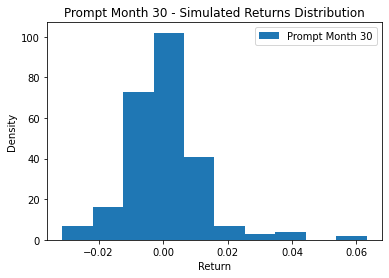

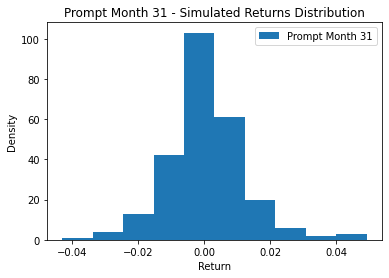

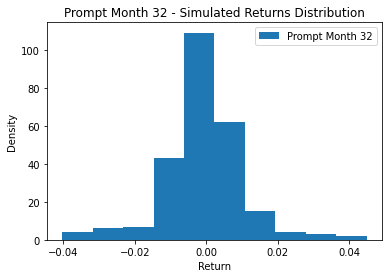

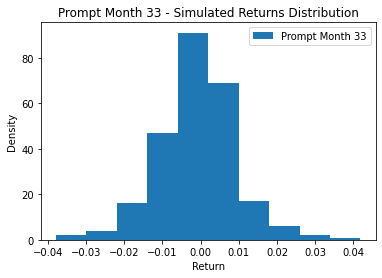

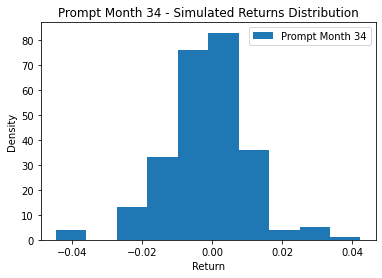

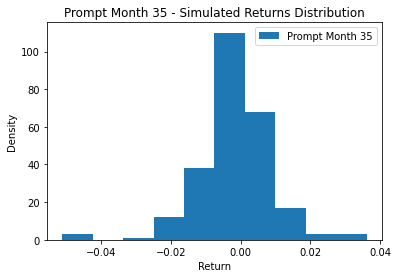

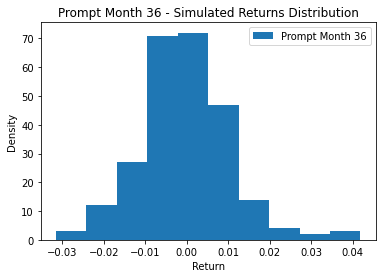

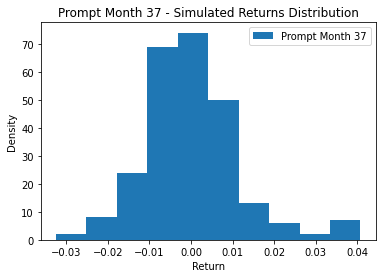

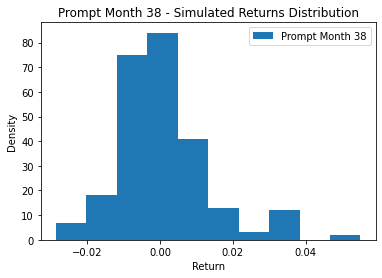

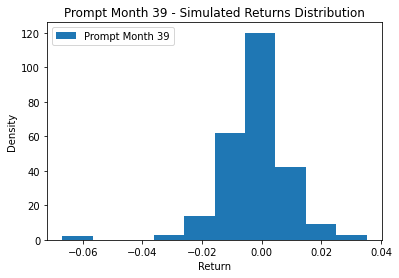

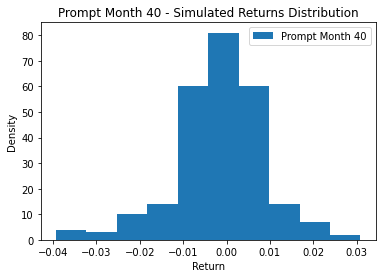

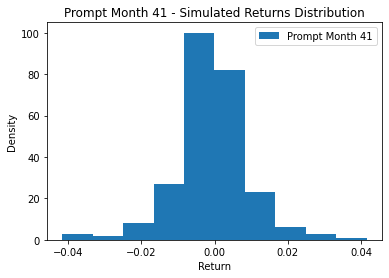

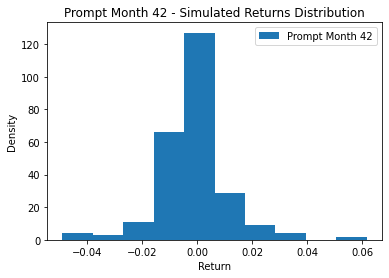

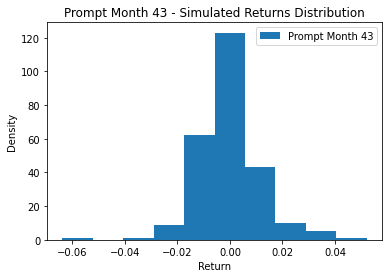

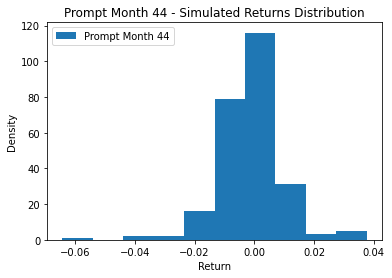

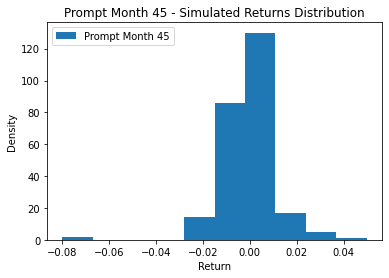

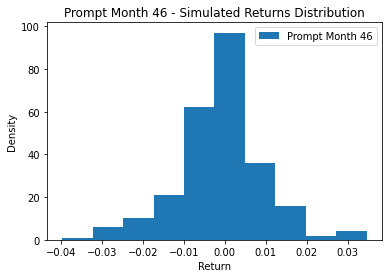

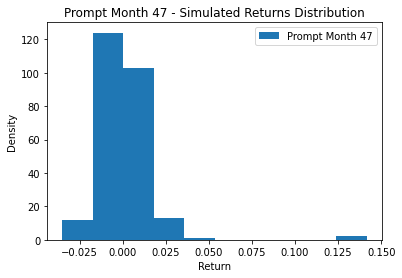

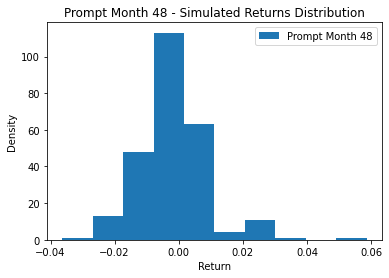

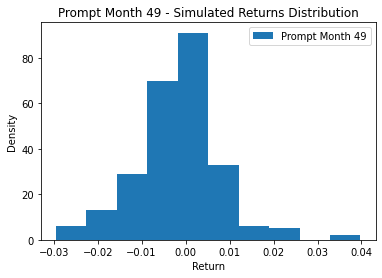

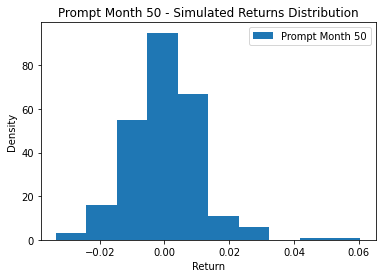

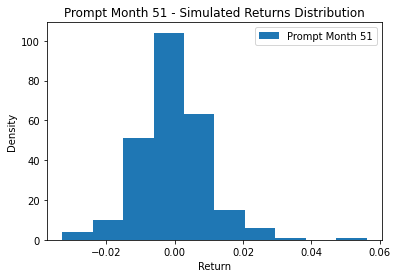

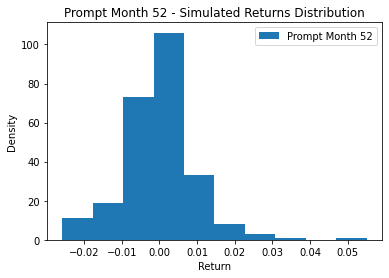

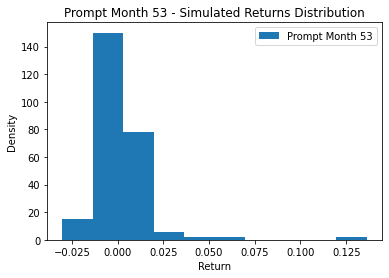

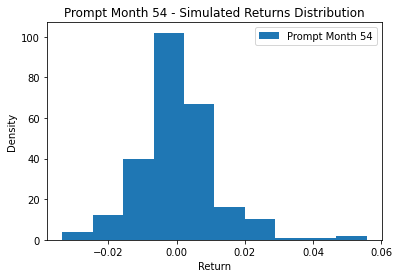

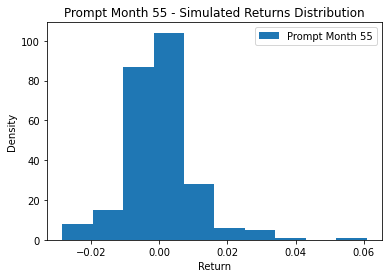

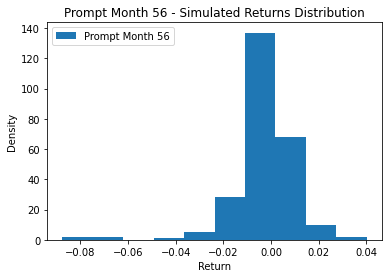

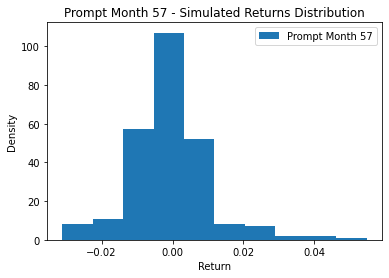

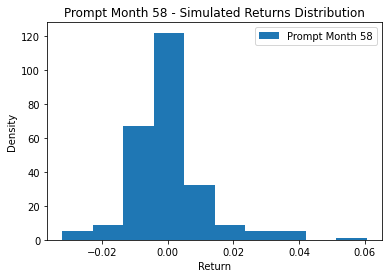

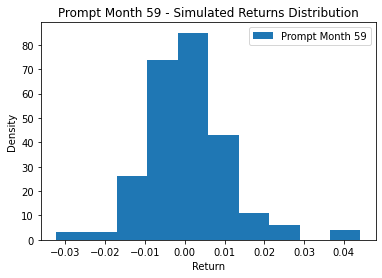

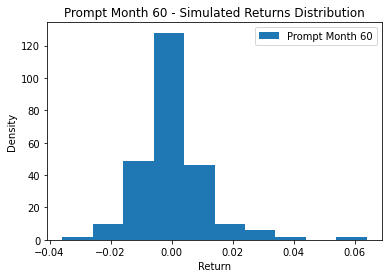

In [120]:
for prompt_month in range(1,len(simulated_data_by_prompt_direct_sampling)+1):
    plt.hist(simulated_data_by_prompt_direct_sampling[prompt_month], label=f'Prompt Month {prompt_month}')
    plt.title(f'Prompt Month {prompt_month} - Simulated Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [107]:
def compute_kde_for_group(data, bandwidth=None):
    """Compute the KDE for a group."""
    return gaussian_kde(data, bw_method=bandwidth)

def monte_carlo_simulation_for_kde(kde, num_simulations=10):
    """Generate simulated returns using a pre-computed KDE."""
    data_min, data_max = kde.dataset.min(), kde.dataset.max()
    inverse_kde_interp = compute_inverse_kde(kde, data_min, data_max)
    u_vals = np.random.uniform(size=num_simulations)
    simulated_returns = inverse_kde_interp(u_vals)
    return simulated_returns

# Adjust main execution
def main_simulation_efficient(data, num_simulations=10, bandwidth=0.2):
    # 1. Compute KDE for each group
    grouped = data.groupby('prompt_month')
    kdes_by_prompt = grouped['hist_return'].apply(lambda group: compute_kde_for_group(group, bandwidth))
    
    # 2. Use KDE to simulate data
    simulated_data_by_prompt = kdes_by_prompt.apply(lambda kde: monte_carlo_simulation_for_kde(kde, num_simulations))
    
    return simulated_data_by_prompt

# Execute the adjusted simulation with a smaller number of simulations for efficiency
bandwidths = [0.05, 0.1, 0.15, 0.2, 0.25]  
num_simulations_small = 10
start = time.time()
simulated_data_by_prompt_efficient = main_simulation_efficient(data, num_simulations_small, 0.2)
end = time.time()
simulated_data_by_prompt_efficient
print(end-start)

1298.970285654068


In [111]:
simulated_data_by_prompt_efficient[1]

array([-3.19560858e-06, -4.83634385e-02, -1.74659484e-02, -2.92567097e-02,
       -5.80016752e-04, -8.58831195e-03, -7.90152463e-03, -1.27083925e-02,
       -3.07561373e-02,  7.63961652e-03])

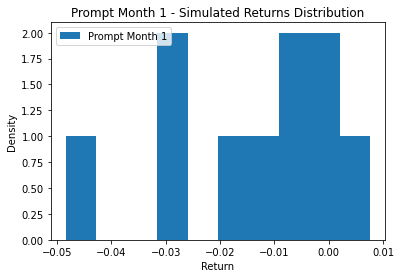

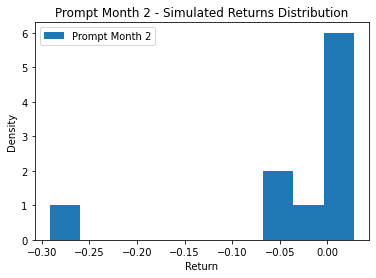

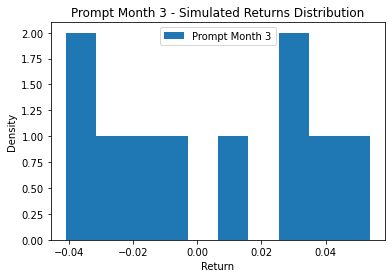

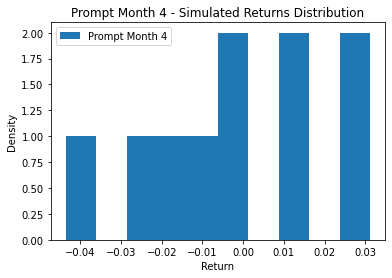

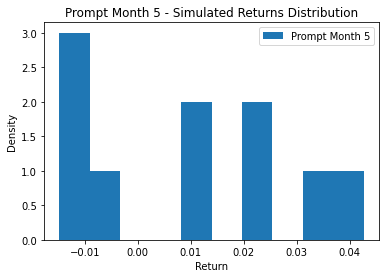

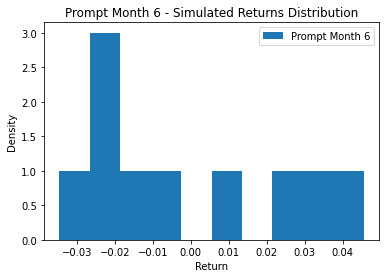

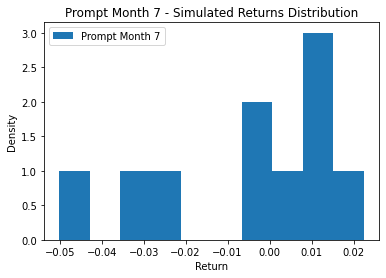

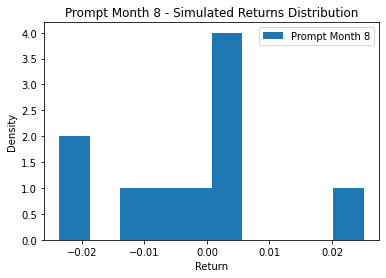

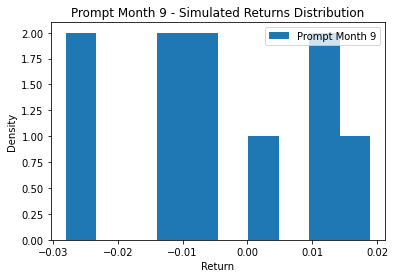

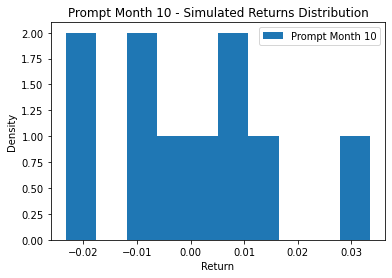

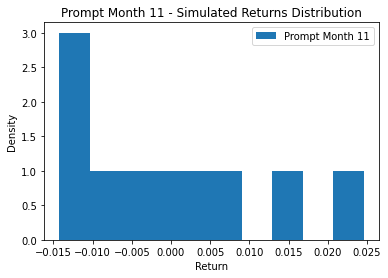

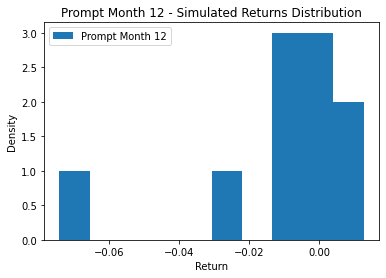

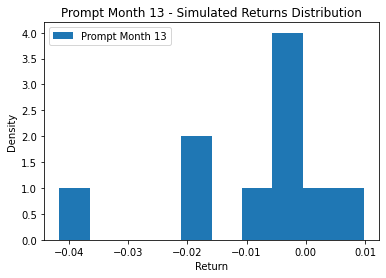

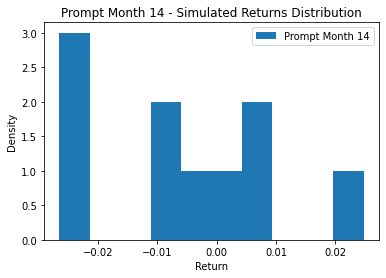

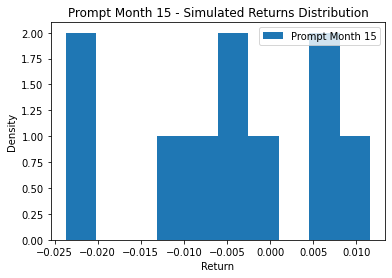

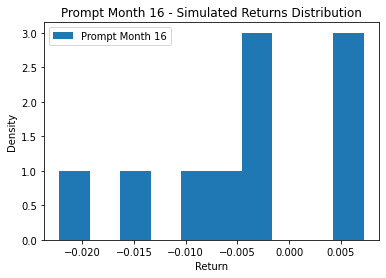

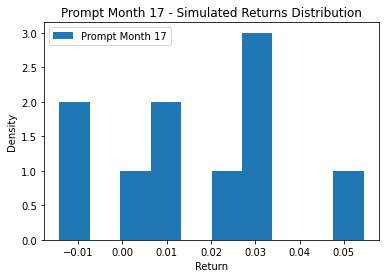

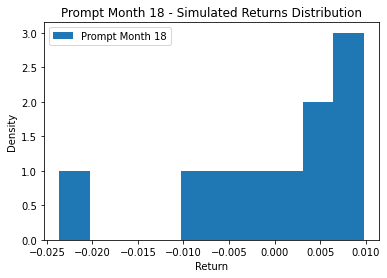

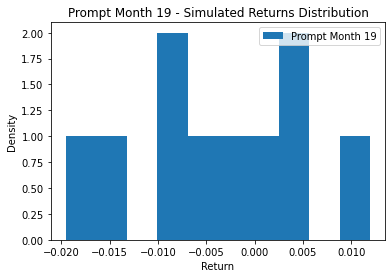

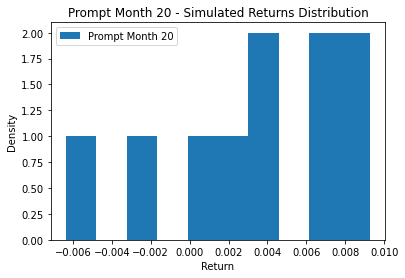

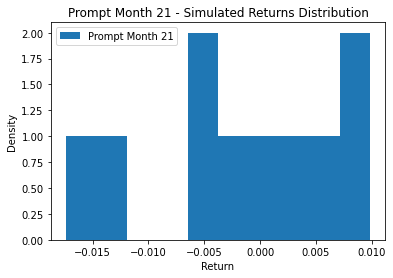

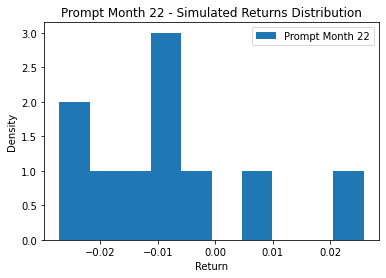

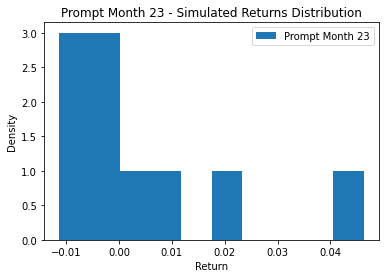

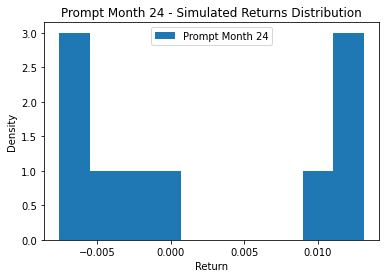

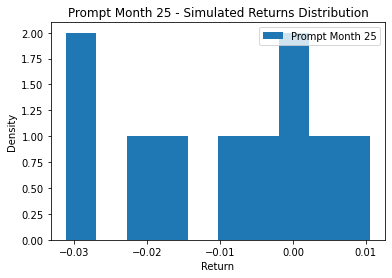

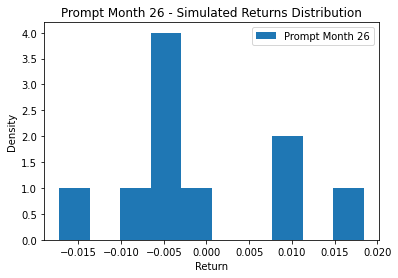

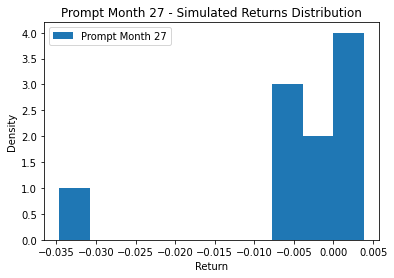

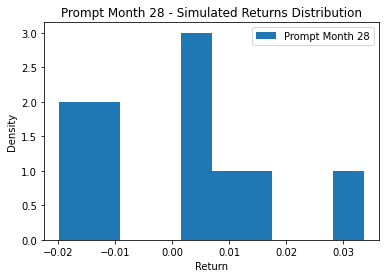

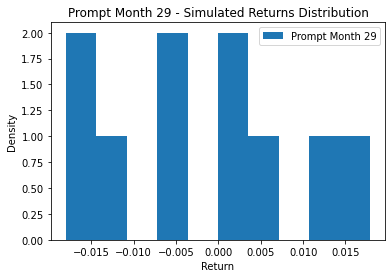

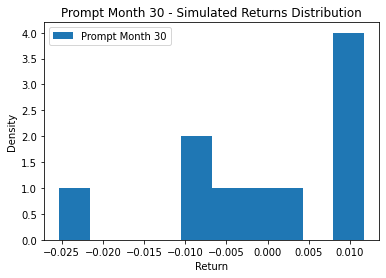

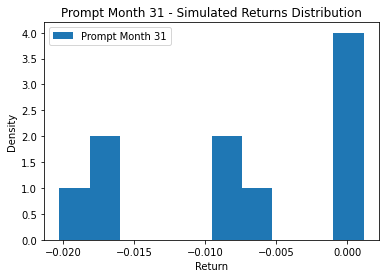

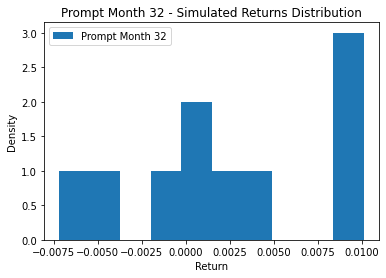

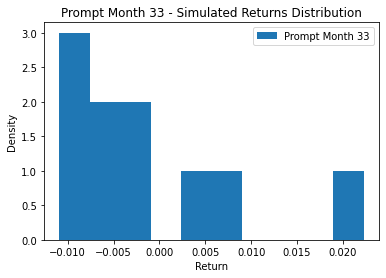

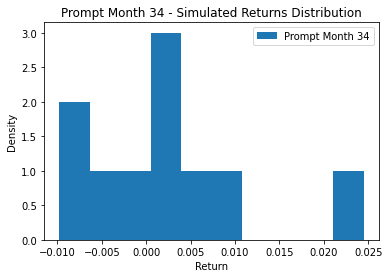

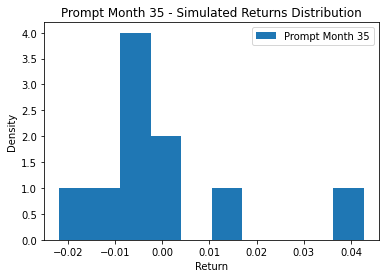

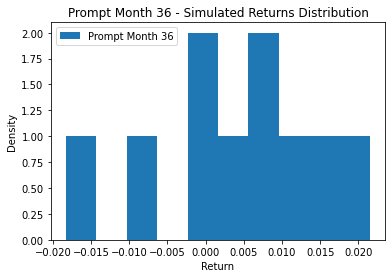

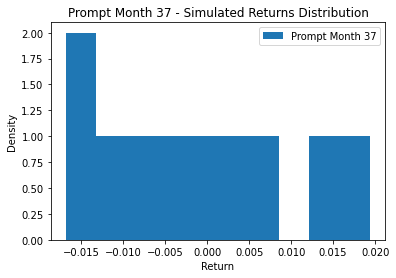

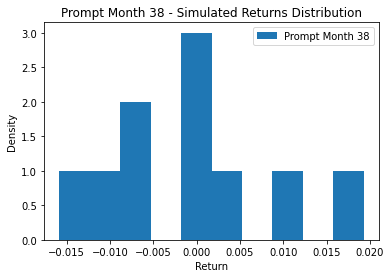

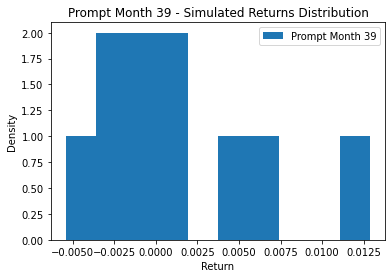

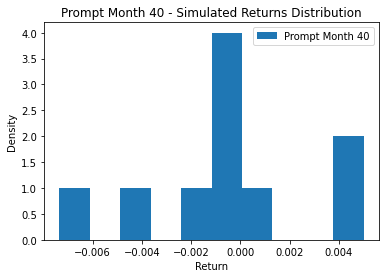

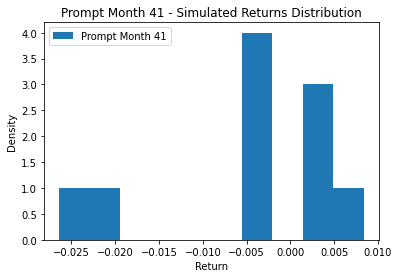

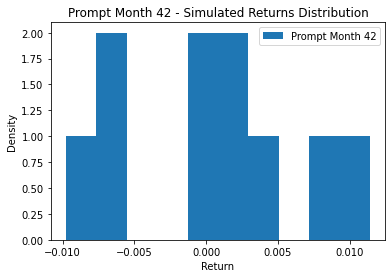

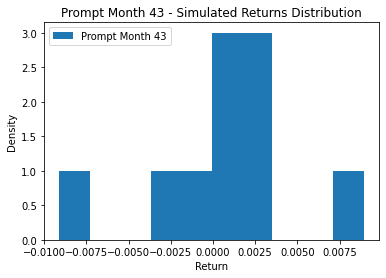

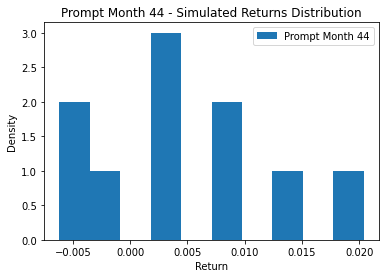

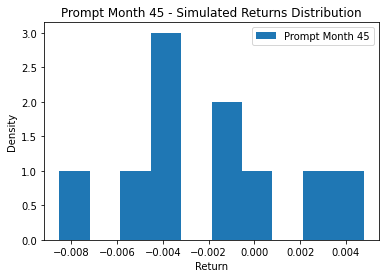

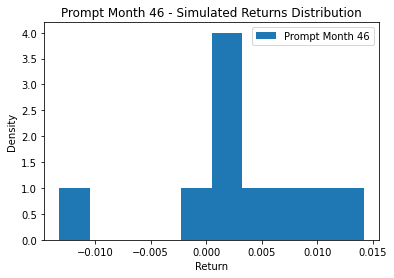

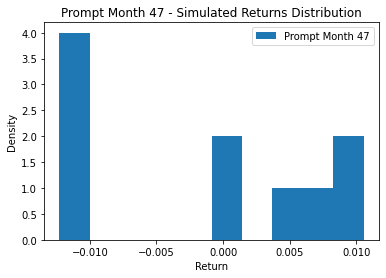

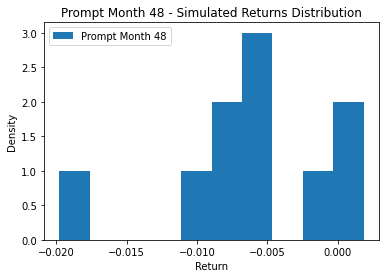

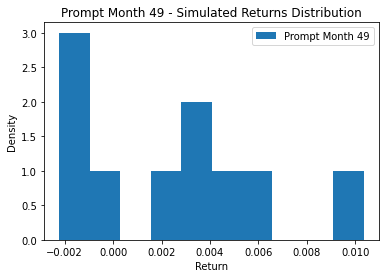

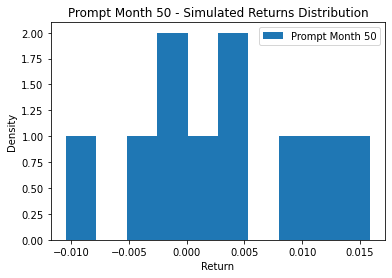

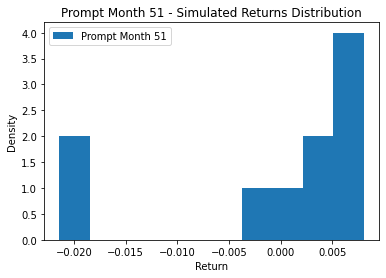

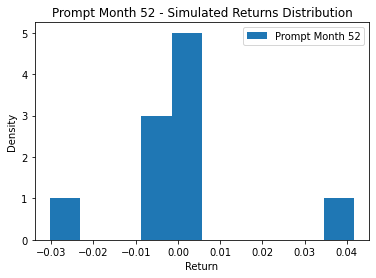

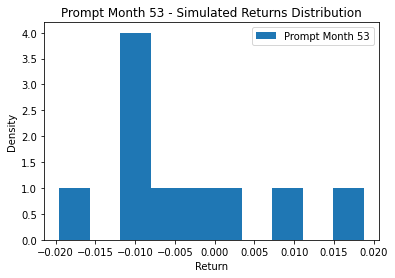

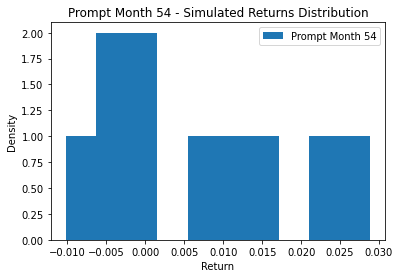

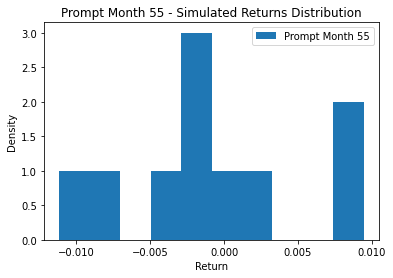

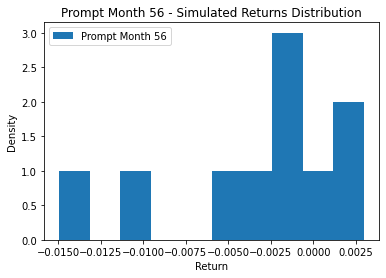

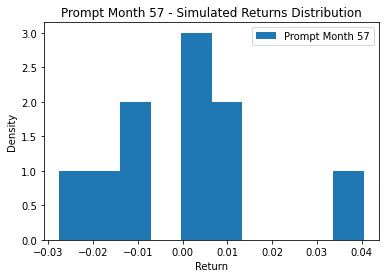

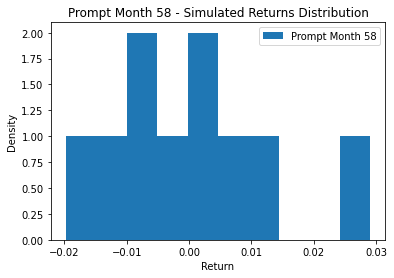

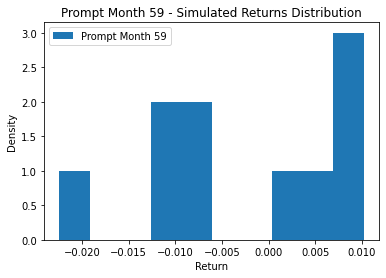

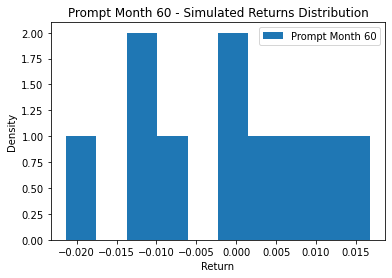

In [113]:
import seaborn as sns

# Plotting KDE plots for each prompt month (for the first simulation as an example)
for prompt_month in range(1,len(simulated_data_by_prompt_efficient)+1):
    plt.hist(simulated_data_by_prompt_efficient[prompt_month], label=f'Prompt Month {prompt_month}')
    plt.title(f'Prompt Month {prompt_month} - Simulated Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


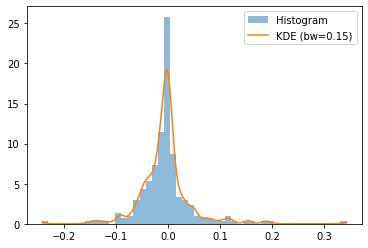

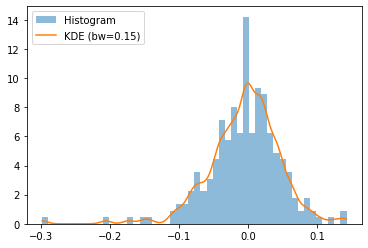

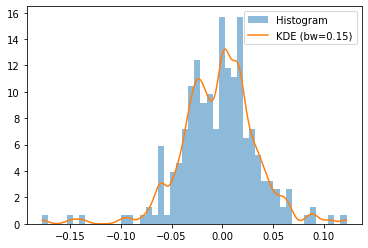

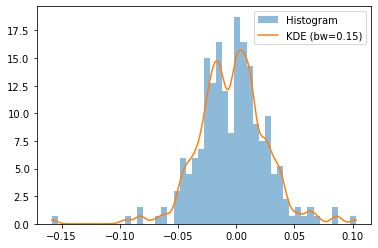

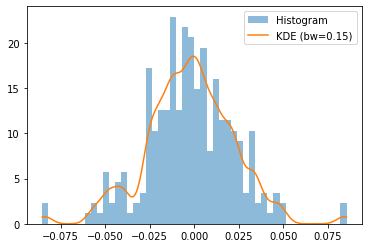

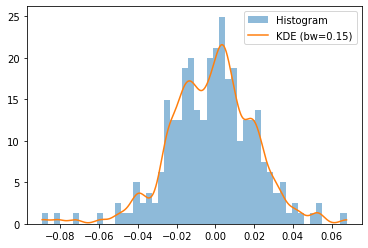

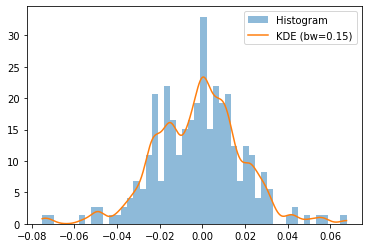

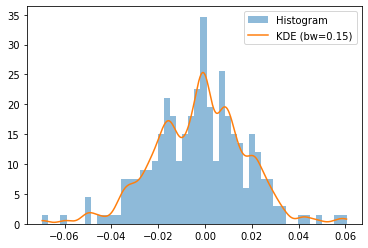

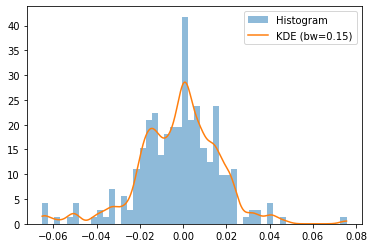

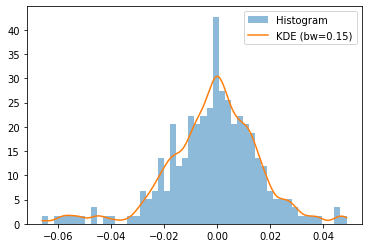

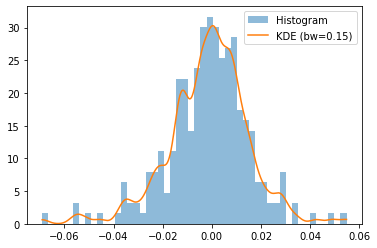

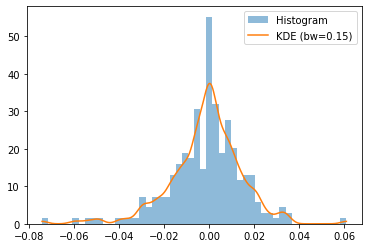

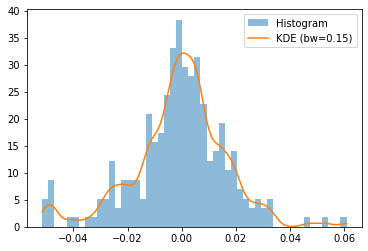

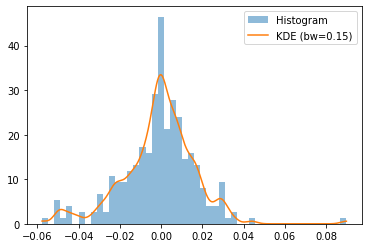

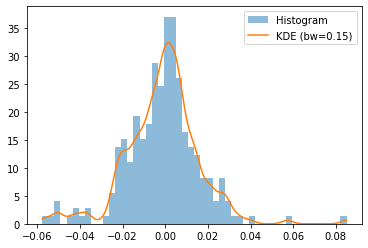

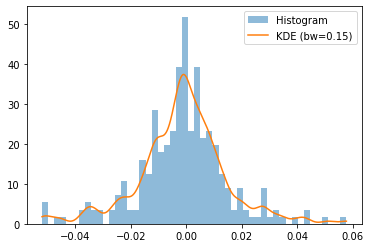

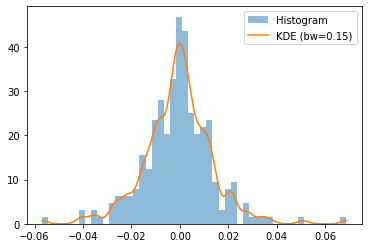

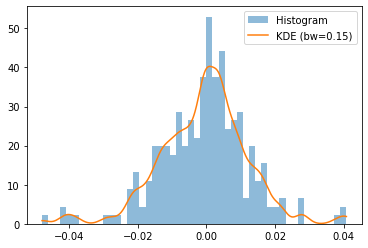

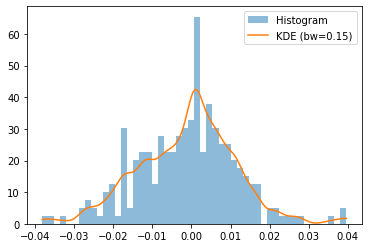

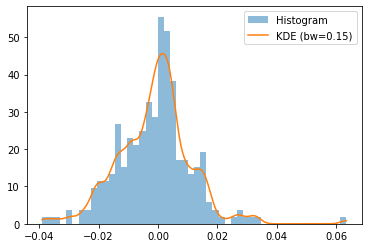

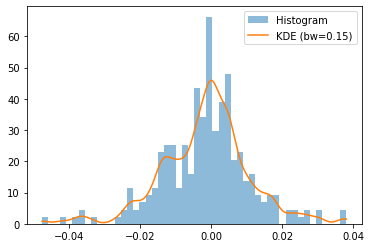

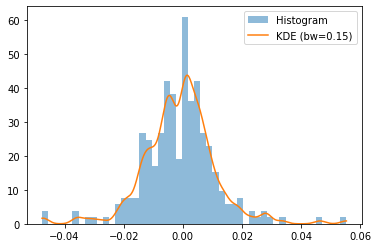

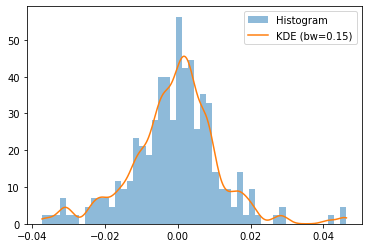

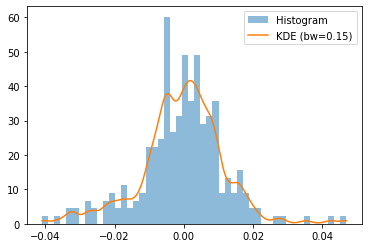

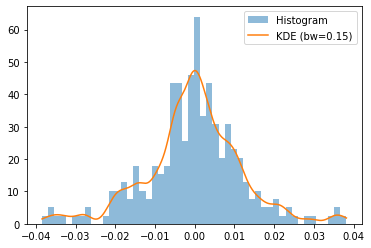

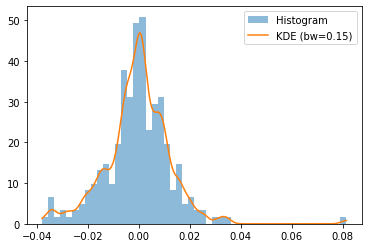

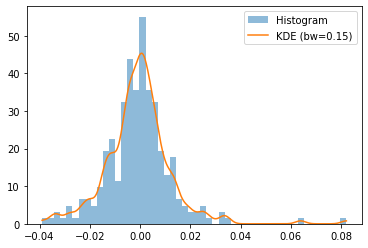

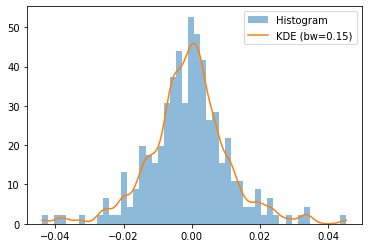

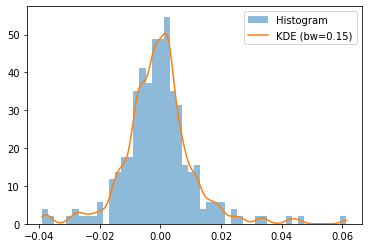

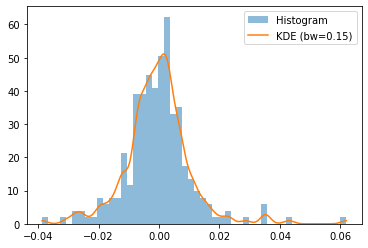

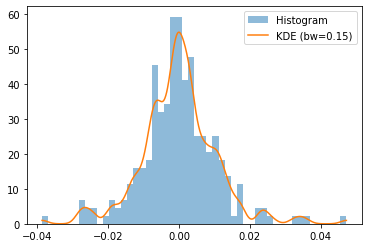

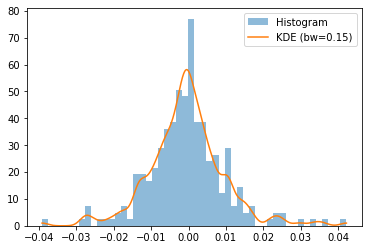

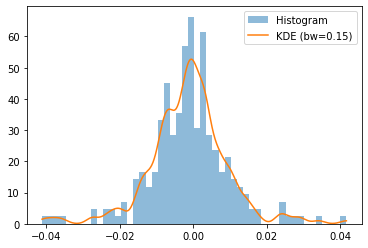

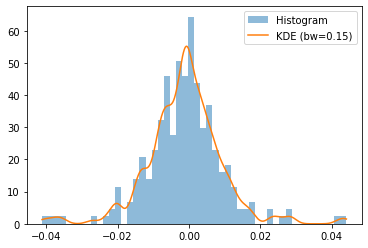

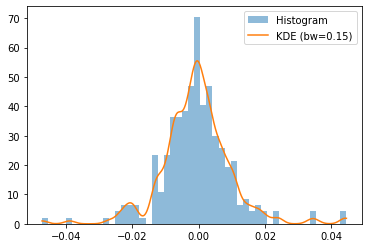

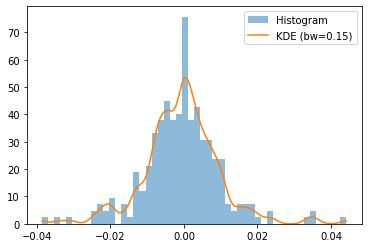

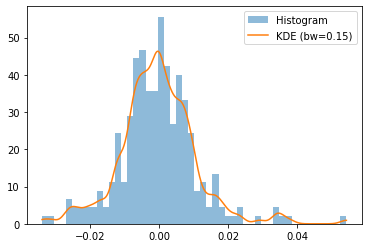

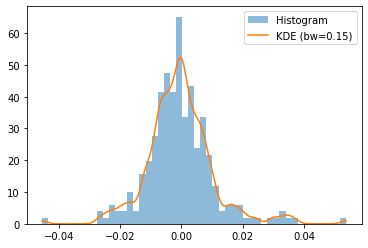

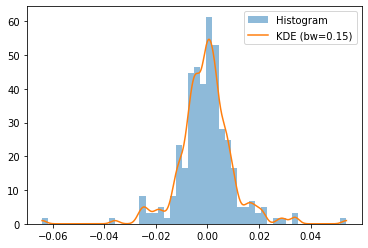

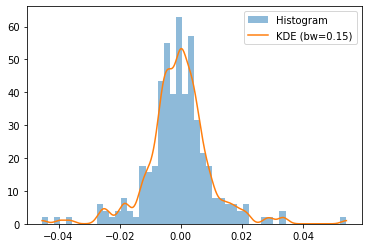

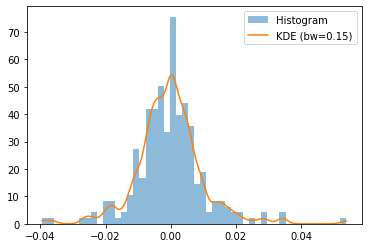

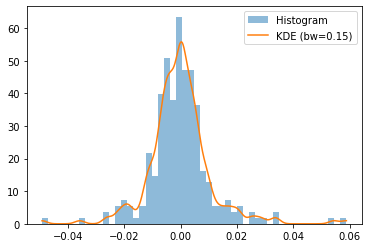

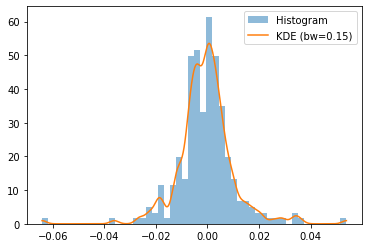

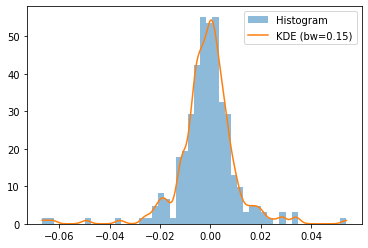

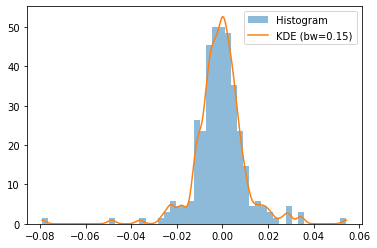

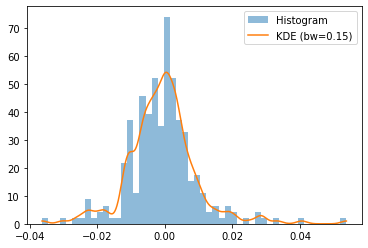

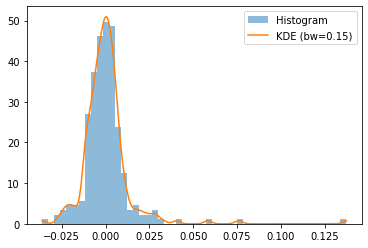

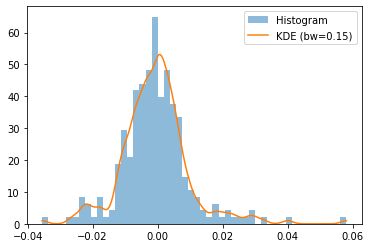

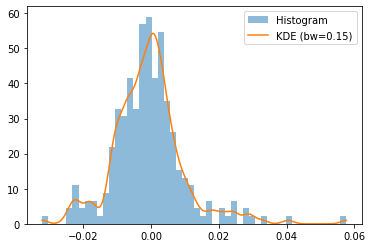

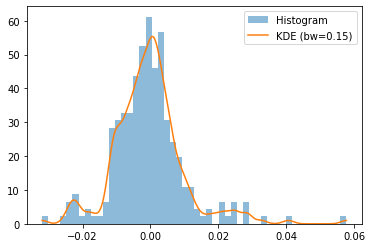

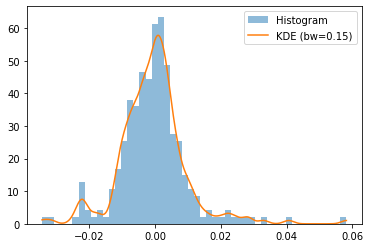

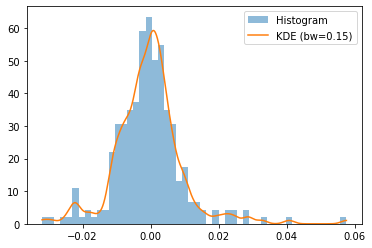

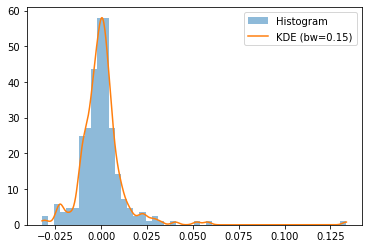

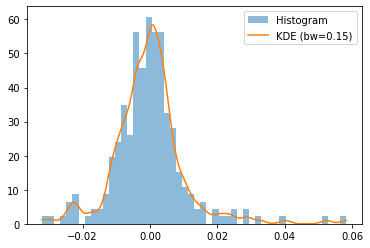

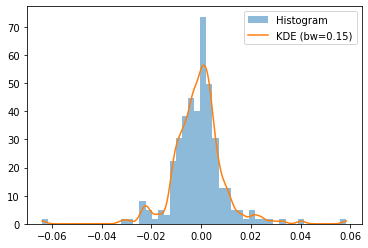

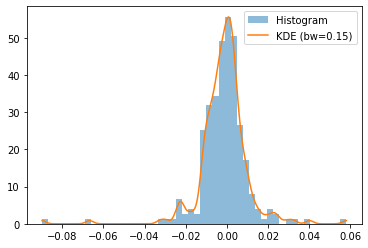

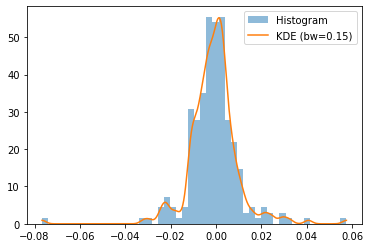

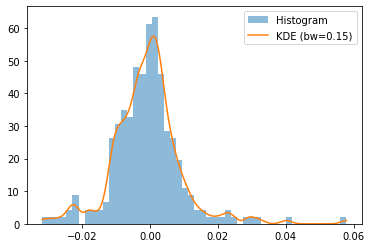

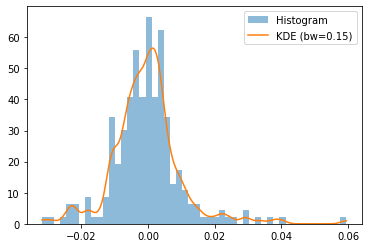

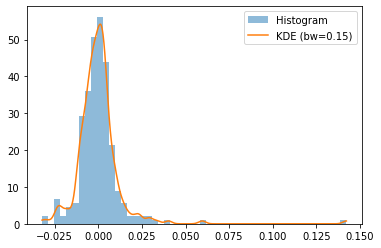

,0
prompt_month,
1,"[[8.420686772899269e-06, 0.002071071384160396,..."
2,"[[0.0741101228976967, -0.025177364207310704, -..."
3,"[[-0.030888910586168532, 0.07598327272444531, ..."
4,"[[-0.055004521178907, 0.01350062654233366, 0.0..."
5,"[[-0.021435087752221915, 0.023685888520289758,..."
6,"[[0.00024119976158936914, 0.049787608398589915..."
7,"[[0.03151903171665704, 0.003441359253853398, 0..."
8,"[[0.01898597730408073, 0.00839877804272417, -0..."
9,"[[0.01919051731853093, -0.0022735418632543044,..."


Algorithm took 1586.1186809539795 seconds.


In [84]:
# KDE Functions
def plot_kde_against_histogram(data, bandwidth=None):
    """Visualizes the KDE against the histogram."""
    plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram")
    kde = gaussian_kde(data, bw_method=bandwidth)
    x_vals = np.linspace(min(data), max(data), 1000)
    plt.plot(x_vals, kde(x_vals), label=f"KDE (bw={bandwidth})")
    plt.legend()
    plt.show()
    return kde

def evaluate_bandwidths(data, bandwidths):
    """Visualizes KDE for a range of bandwidths."""
    plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram")
    for bw in bandwidths:
        kde = gaussian_kde(data, bw_method=bw)
        x_vals = np.linspace(min(data), max(data), 1000)
        plt.plot(x_vals, kde(x_vals), label=f"KDE (bw={bw})")
    plt.legend()
    plt.show()

def kde_cdf(x, kde):
    """Computes the CDF of the KDE."""
    return quad(kde.pdf, -np.inf, x)[0]

def compute_inverse_kde(kde, data_min, data_max, num_points=1000):
    """Pre-compute inverse KDE CDF using interpolation."""
    x = np.linspace(data_min, data_max, num_points)
    cdf_vals = np.array([kde_cdf(xi, kde) for xi in x])
    return interp1d(cdf_vals, x, bounds_error=False, fill_value=(data_min, data_max))

def monte_carlo_simulation_adjusted(data, num_simulations=10, bandwidth=None):
    """Adjusted Monte Carlo simulation using pre-computed inverse KDE."""
    kde = plot_kde_against_histogram(data.hist_return, bandwidth=bandwidth)
    data_min, data_max = min(data.hist_return), max(data.hist_return)
    
    inverse_kde_interp = compute_inverse_kde(kde, data_min, data_max)
    
    u_vals = np.random.uniform(size=(1, num_simulations))
    simulated_prices = inverse_kde_interp(u_vals)
    
    # Adjust simulated prices to match the original data's mean and standard deviation
    simulated_prices = (simulated_prices - np.mean(simulated_prices)) / np.std(simulated_prices)
    simulated_prices = simulated_prices * np.std(data.hist_return) + np.mean(data.hist_return)
    
    return simulated_prices.tolist()

if __name__ == "__main__":
    bandwidths = [0.05, 0.1, 0.15, 0.2, 0.25]  
#     evaluate_bandwidths(data.hist_return, bandwidths)
    
    num_simulations = 10
    grouped = data.groupby('prompt_month')
    
    algo_start = time.time()
    simulated_data = grouped.apply(lambda group: monte_carlo_simulation_adjusted(group, num_simulations, bandwidth=0.15))
    algo_end = time.time()
    
    # Convert to DataFrame 
    df_simulations = pd.DataFrame(simulated_data)
    display(df_simulations)
    
#     fig, axes = plt.subplots(nrows=(num_simulations//5), ncols=5, figsize=(40,80))

#     for i, ax in enumerate(axes.ravel()):
#         df_simulations[i].hist(ax=ax)
#         ax.set_title(f'Sim {i+1} Prices')
#         ax.set_xlabel('Price')
#         ax.set_ylabel('Frequency')

# #     plt.tight_layout()
#     plt.show()
    
    print(f'Algorithm took {(algo_end-algo_start)} seconds.')

(array([1., 0., 0., 0., 3., 1., 2., 1., 0., 2.]),
 array([-0.12020344, -0.10077208, -0.08134072, -0.06190937, -0.04247801,
        -0.02304666, -0.0036153 ,  0.01581606,  0.03524741,  0.05467877,
         0.07411012]),
 <BarContainer object of 10 artists>)

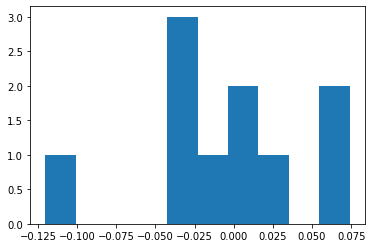

In [95]:
plt.hist(df_simulations.iloc[1,0][0])

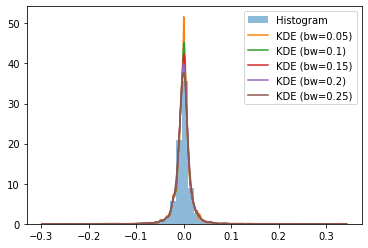

KeyboardInterrupt: 

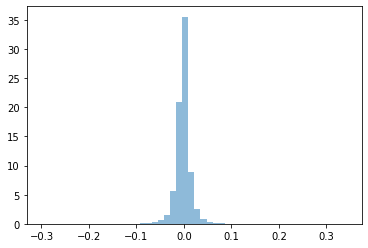

In [19]:
# KDE Functions
def plot_kde_against_histogram(data, bandwidth=None):
    """Visualizes the KDE against the histogram."""
    plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram")
    kde = gaussian_kde(data, bw_method=bandwidth)
    x_vals = np.linspace(min(data), max(data), 1000)
    plt.plot(x_vals, kde(x_vals), label=f"KDE (bw={bandwidth})")
    plt.legend()
    plt.show()
    return kde

def evaluate_bandwidths(data, bandwidths):
    """Visualizes KDE for a range of bandwidths."""
    plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram", title = title)
    for bw in bandwidths:
        kde = gaussian_kde(data, bw_method=bw)
        x_vals = np.linspace(min(data), max(data), 1000)
        plt.plot(x_vals, kde(x_vals), label=f"KDE (bw={bw})")
    plt.legend()
    plt.show()

def kde_cdf(x, kde):
    """Computes the CDF of the KDE."""
    return quad(kde.pdf, -np.inf, x)[0]

def compute_inverse_kde(kde, data_min, data_max, num_points=1000):
    """Pre-compute inverse KDE CDF using interpolation."""
    x = np.linspace(data_min, data_max, num_points)
    cdf_vals = np.array([kde_cdf(xi, kde) for xi in x])
    return interp1d(cdf_vals, x, bounds_error=False, fill_value=(data_min, data_max))

def monte_carlo_simulation_adjusted(data, num_simulations=10, bandwidth=None):
    """Adjusted Monte Carlo simulation using pre-computed inverse KDE."""
    kde = plot_kde_against_histogram(data.hist_return, bandwidth=bandwidth)
    data_min, data_max = min(data.hist_return), max(data.hist_return)
    
    inverse_kde_interp = compute_inverse_kde(kde, data_min, data_max)
    
    u_vals = np.random.uniform(size=(len(data), num_simulations))
    simulated_prices = inverse_kde_interp(u_vals)
    
    # Adjust simulated prices to match the original data's mean and standard deviation
    simulated_prices = (simulated_prices - np.mean(simulated_prices)) / np.std(simulated_prices)
    simulated_prices = simulated_prices * np.std(data.hist_return) + np.mean(data.hist_return)
    display(simulated_prices)
    print(type(simulated_prices))
    
    return simulated_prices.tolist()

if __name__ == "__main__":
    bandwidths = [0.05, 0.1, 0.15, 0.2, 0.25]  
    evaluate_bandwidths(data.hist_return, bandwidths)
    
    num_simulations = 252
    
    algo_start = time.time()
    simulated_data = monte_carlo_simulation_adjusted(data, num_simulations, bandwidth=0.2)
    algo_end = time.time()
    
    # Convert to DataFrame 
    df_simulations = pd.DataFrame(simulated_data)
    display(df_simulations)
    
    fig, axes = plt.subplots(nrows=(num_simulations//5), ncols=5, figsize=(40,80))

    for i, ax in enumerate(axes.ravel()):
        df_simulations[i].hist(ax=ax)
        ax.set_title(f'Sim {i+1} Prices')
        ax.set_xlabel('Price')
        ax.set_ylabel('Frequency')

#     plt.tight_layout()
    plt.show()
    
    print(f'Algorithm took {(algo_end-algo_start)} seconds.')

In [5]:
df_simulations.index = range(1,73)
df_simulations.index.name = 'Prompt Month'

df_simulations.columns = [f'Sim_{i}' for i in range(1,num_simulations+1)]
df_simulations.to_csv(r"P:\Scott\KJ\MC VaR\simulated_prices_kde_method.csv")
df_simulations

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,Sim_10,...,Sim_243,Sim_244,Sim_245,Sim_246,Sim_247,Sim_248,Sim_249,Sim_250,Sim_251,Sim_252
Prompt Month,,,,,,,,,,,,,,,,,,,,,
1,60.92758,49.15230,67.79512,67.07623,61.65788,50.42148,53.37082,74.94854,66.16107,47.54960,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
2,45.02769,54.52502,72.91011,69.16494,66.72773,48.79891,75.20469,45.02769,45.65005,45.02769,...,52.11478,46.91895,66.49880,53.77954,45.02769,54.53796,46.83480,64.88714,46.32739,67.54696
3,69.04171,66.56938,48.08238,51.79039,73.09778,50.33828,46.48795,49.17570,65.09838,66.26305,...,75.16376,47.61664,66.12018,45.02769,46.88920,70.40972,52.13092,45.02769,48.42873,66.02263
4,48.11828,47.96713,51.89299,45.02769,45.02769,68.66337,69.43862,74.29770,52.02098,75.08192,...,62.63446,68.89629,62.08040,48.61962,46.04056,56.55233,74.87348,69.26527,46.31715,74.21912
5,71.56925,47.39180,46.64334,49.13405,47.35272,46.10459,74.43507,72.07553,67.68419,61.51546,...,66.90779,68.37104,47.35501,55.80787,67.14256,62.61944,47.67164,62.27912,47.50451,64.05143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,70.63234,45.50155,49.42595,48.96391,75.20469,57.49719,45.02769,56.46145,53.35029,56.08346,...,52.62803,48.02087,56.16073,75.20469,50.12916,46.07483,49.89681,67.99018,60.10777,59.06197
69,56.94526,70.50460,49.21560,51.67646,51.01894,45.02769,47.79391,68.33518,46.69195,61.46567,...,47.11403,50.94463,47.09875,74.42799,70.20863,45.81122,47.87904,45.82658,46.74923,52.14128
70,46.80322,67.54975,49.62037,46.56555,72.82212,59.20737,75.20469,53.09551,59.66820,51.42384,...,69.12718,70.00525,52.02882,70.30662,67.31322,68.97744,70.63191,62.13471,46.02558,69.24334


In [6]:
data.price.index = range(1,73)
data.price.index.name = 'Prompt Month'
data.price

Prompt Month
1    45.65000
2    53.50000
3    73.50000
4    67.20000
5    49.05000
       ...   
68   50.95000
69   68.10000
70   62.35000
71   50.25000
72   45.95000
Name: price, Length: 72, dtype: float64

In [7]:
sim_returns = df_simulations.apply(lambda x: (x - data.price)/data.price)
sim_returns.to_csv(r"P:\Scott\KJ\MC VaR\simulated_returns_kde_method.csv")
sim_returns

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,Sim_10,...,Sim_243,Sim_244,Sim_245,Sim_246,Sim_247,Sim_248,Sim_249,Sim_250,Sim_251,Sim_252
Prompt Month,,,,,,,,,,,,,,,,,,,,,
1,0.33467,0.07672,0.48511,0.46936,0.35067,0.10452,0.16913,0.64181,0.44931,0.04161,...,0.46615,0.02017,0.08353,0.49005,0.10999,-0.01363,0.43383,0.50621,0.12926,0.41311
2,-0.15836,0.01916,0.36281,0.29280,0.24725,-0.08787,0.40570,-0.15836,-0.14673,-0.15836,...,-0.02589,-0.12301,0.24297,0.00523,-0.15836,0.01940,-0.12458,0.21284,-0.13407,0.26256
3,-0.06066,-0.09429,-0.34582,-0.29537,-0.00547,-0.31513,-0.36751,-0.33094,-0.11431,-0.09846,...,0.02264,-0.35215,-0.10041,-0.38738,-0.36205,-0.04204,-0.29074,-0.38738,-0.34111,-0.10173
4,-0.28395,-0.28620,-0.22778,-0.32995,-0.32995,0.02178,0.03331,0.10562,-0.22588,0.11729,...,-0.06794,0.02524,-0.07618,-0.27649,-0.31487,-0.15845,0.11419,0.03073,-0.31076,0.10445
5,0.45911,-0.03381,-0.04907,0.00171,-0.03460,-0.06005,0.51753,0.46943,0.37990,0.25414,...,0.36407,0.39390,-0.03456,0.13778,0.36886,0.27664,-0.02810,0.26971,-0.03151,0.30584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.38631,-0.10694,-0.02991,-0.03898,0.47605,0.12850,-0.11624,0.10817,0.04711,0.10075,...,0.03293,-0.05749,0.10227,0.47605,-0.01611,-0.09569,-0.02067,0.33445,0.17974,0.15921
69,-0.16380,0.03531,-0.27730,-0.24117,-0.25082,-0.33880,-0.29818,0.00345,-0.31436,-0.09742,...,-0.30816,-0.25191,-0.30839,0.09292,0.03096,-0.32729,-0.29693,-0.32707,-0.31352,-0.23434
70,-0.24935,0.08340,-0.20416,-0.25316,0.16796,-0.05040,0.20617,-0.14843,-0.04301,-0.17524,...,0.10870,0.12278,-0.16554,0.12761,0.07960,0.10629,0.13283,-0.00345,-0.26182,0.11056


In [8]:
futures_positions = """
declare @as_of_date date = '10-11-2023';
with base_data
  as (select emm.var_ticker, p.contract_month, sum(p.delta_position) position
              from position_snapshot_v3 p
              inner join e360_master_mapping emm
                 on p.primary_product_code = emm.molecule_product_code
           where as_of_date = @as_of_date 
                and emm.var_ticker in('PMI')
                and p.deal_type = 'future'
                and p.status = 'unrealized'
				and contract_month > datefromparts(year(@as_of_date), month(@as_of_date),1)
         group by emm.var_ticker, p.contract_month
       )
       select var_ticker
             , rank() over(partition by var_ticker order by contract_month asc) prompt_month
                , contract_month
                , position
          from base_data
     order by contract_month
"""

futures = pd.read_sql(futures_positions, cnxn)
futures.index = range(1,len(futures)+1)
futures.index.name = 'Prompt Month'
futures.drop(columns = 'prompt_month', inplace = True)
futures

C:\Users\kjones\AppData\Local\Temp\ipykernel_63892\1415774175.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  futures = pd.read_sql(futures_positions, cnxn)


,var_ticker,contract_month,position
Prompt Month,,,
1,PMI,2023-11-01,"184,128.00000"
2,PMI,2023-12-01,"-18,240.00000"
3,PMI,2024-01-01,"-90,464.00000"
4,PMI,2024-02-01,"-85,680.00000"
5,PMI,2024-03-01,"-53,088.00000"
6,PMI,2024-04-01,"-63,008.00000"
7,PMI,2024-05-01,"12,320.00000"
8,PMI,2024-06-01,"10,880.00000"
9,PMI,2024-07-01,"-96,096.00000"


In [9]:
futs_vectors = pd.concat([futures, sim_returns.iloc[:50]], axis = 1)

for i in range(1, len(sim_returns.columns)+1):
    futs_vectors[f'PnL_{i}'] = futs_vectors.position * futs_vectors[f'Sim_{i}']
    futs_vectors.drop(columns = f'Sim_{i}', inplace=True)
    
futs_vectors.T

Prompt Month,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
var_ticker,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI,...,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI,PMI
contract_month,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,...,2027-03-01,2027-04-01,2027-05-01,2027-06-01,2027-07-01,2027-08-01,2027-09-01,2027-10-01,2027-11-01,2027-12-01
position,"184,128.00000","-18,240.00000","-90,464.00000","-85,680.00000","-53,088.00000","-63,008.00000","12,320.00000","10,880.00000","-96,096.00000","-95,392.00000",...,368.00000,352.00000,320.00000,352.00000,336.00000,352.00000,336.00000,336.00000,336.00000,368.00000
PnL_1,"61,621.70015","2,888.50500","5,487.27853","24,329.18772","-24,373.12348","-25,277.43688",414.93738,637.84097,"25,645.71881","22,102.07737",...,-17.82024,169.71751,3.83084,32.03506,-103.44539,-67.40366,152.39919,214.51801,167.71473,-84.09297
PnL_2,"14,126.43756",-349.46369,"8,530.23173","24,521.90626","1,794.70943","-2,748.31891","3,444.10705",-830.74425,"26,055.82989","17,175.10674",...,15.32151,-3.82327,127.30276,-27.70931,32.88725,-81.06423,165.36462,10.75951,3.25817,-87.00773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PnL_248,"-2,510.08835",-353.87603,"3,803.52377","13,575.77788","-14,686.52894","-27,840.69621",-579.44794,-665.20061,"20,789.86110","14,281.78554",...,121.16755,31.62909,137.00506,-41.22068,-82.48435,-97.99767,-8.62626,35.48136,112.07634,-77.26793
PnL_249,"79,879.81560","2,272.39870","26,301.12670","-9,783.68844","1,491.82885","-8,334.54729",183.62483,"5,904.14484","12,457.69230","10,311.78013",...,-25.76352,14.33982,91.22896,160.61883,-37.15876,-68.51001,-35.81543,10.36002,-18.01388,-81.29952
PnL_250,"93,208.02055","-3,882.27100","35,043.80222","-2,633.22395","-14,318.19942","-31,066.56595",-113.54789,"2,346.96412","30,472.55857","-8,363.52612",...,120.27699,157.64864,13.78572,157.75769,-79.74092,-78.09507,152.79978,214.51801,155.05896,-19.07790
PnL_251,"23,799.54110","2,445.38959","30,857.79185","26,625.63940","1,672.72597","-4,915.50909",-132.27361,149.43647,"24,776.18820","22,818.76508",...,-23.79232,10.24426,141.37407,26.79101,-31.76730,4.44243,-10.48860,-5.29177,-13.26589,-66.06477


In [10]:
for i in range(1, 51):
    var_value = np.percentile(futs_vectors.iloc[i-1, 3:].T, 1) 
    futs_vectors.loc[i, '99th_Percentile_PnL'] = var_value

futs_vectors

,var_ticker,contract_month,position,PnL_1,PnL_2,PnL_3,PnL_4,PnL_5,PnL_6,PnL_7,...,PnL_244,PnL_245,PnL_246,PnL_247,PnL_248,PnL_249,PnL_250,PnL_251,PnL_252,99th_Percentile_PnL
Prompt Month,,,,,,,,,,,,,,,,,,,,,
1,PMI,2023-11-01,"184,128.00000","61,621.70015","14,126.43756","89,321.72512","86,422.10605","64,567.32268","19,245.65012","31,141.70669",...,"3,713.11383","15,380.22204","90,231.82618","20,252.25758","-2,510.08835","79,879.81560","93,208.02055","23,799.54110","76,064.86423","-2,510.08835"
2,PMI,2023-12-01,"-18,240.00000","2,888.50500",-349.46369,"-6,617.57873","-5,340.71873","-4,509.79040","1,602.76273","-7,399.88041",...,"2,243.70631","-4,431.74144",-95.30498,"2,888.50500",-353.87603,"2,272.39870","-3,882.27100","2,445.38959","-4,789.09332","-7,399.88041"
3,PMI,2024-01-01,"-90,464.00000","5,487.27853","8,530.23173","31,284.07520","26,720.24313",495.05344,"28,507.50937","33,246.50018",...,"31,857.30433","9,083.10714","35,043.80222","32,752.64901","3,803.52377","26,301.12670","35,043.80222","30,857.79185","9,203.16324","-2,098.14091"
4,PMI,2024-02-01,"-85,680.00000","24,329.18772","24,521.90626","19,516.43900","28,269.70105","28,269.70105","-1,865.79576","-2,854.24164",...,"-2,162.77095","6,527.49006","23,689.98229","26,978.29134","13,575.77788","-9,783.68844","-2,633.22395","26,625.63940","-8,949.38214","-10,205.98370"
5,PMI,2024-03-01,"-53,088.00000","-24,373.12348","1,794.70943","2,604.78751",-90.97151,"1,837.00467","3,187.88783","-27,474.87223",...,"-20,911.62470","1,834.52567","-7,314.20296","-19,582.00964","-14,686.52894","1,491.82885","-14,318.19942","1,672.72597","-16,236.40764","-28,307.85622"
6,PMI,2024-04-01,"-63,008.00000","-25,277.43688","-2,748.31891","-6,060.85582","-29,338.57074","-6,438.19687","1,465.60510","-16,855.05874",...,"-32,610.83240","-36,424.57893","1,465.60510","-37,449.21462","-27,840.69621","-8,334.54729","-31,066.56595","-4,915.50909","-2,903.00682","-39,779.36015"
7,PMI,2024-05-01,"12,320.00000",414.93738,"3,444.10705",610.36953,"1,351.87382",433.73400,188.31299,"1,049.96631",...,341.56663,"1,136.86259",258.47444,"1,376.07155",-579.44794,183.62483,-113.54789,-132.27361,"4,403.76096",-579.44794
8,PMI,2024-06-01,"10,880.00000",637.84097,-830.74425,"3,189.22982",-260.27185,"4,083.52595",746.44936,"3,157.45007",...,-124.27344,"4,515.28238",395.90154,"2,534.29384",-665.20061,"5,904.14484","2,346.96412",149.43647,662.22322,-830.74425
9,PMI,2024-07-01,"-96,096.00000","25,645.71881","26,055.82989","32,323.25923","32,323.25923","1,616.35254","29,969.06290","5,929.60510",...,"1,372.81538","29,238.85716","27,422.63998","21,335.23254","20,789.86110","12,457.69230","30,472.55857","24,776.18820","26,667.18582","-10,416.45672"


In [11]:
# Calculate sum of each column
column_sums = futs_vectors.iloc[:, 3:].sum()

# Add new row for column sums
futs_vectors.loc['Total PnL'] = [np.nan] * 3 + column_sums.tolist()

futs_vectors

,var_ticker,contract_month,position,PnL_1,PnL_2,PnL_3,PnL_4,PnL_5,PnL_6,PnL_7,...,PnL_244,PnL_245,PnL_246,PnL_247,PnL_248,PnL_249,PnL_250,PnL_251,PnL_252,99th_Percentile_PnL
Prompt Month,,,,,,,,,,,,,,,,,,,,,
1,PMI,2023-11-01,"184,128.00000","61,621.70015","14,126.43756","89,321.72512","86,422.10605","64,567.32268","19,245.65012","31,141.70669",...,"3,713.11383","15,380.22204","90,231.82618","20,252.25758","-2,510.08835","79,879.81560","93,208.02055","23,799.54110","76,064.86423","-2,510.08835"
2,PMI,2023-12-01,"-18,240.00000","2,888.50500",-349.46369,"-6,617.57873","-5,340.71873","-4,509.79040","1,602.76273","-7,399.88041",...,"2,243.70631","-4,431.74144",-95.30498,"2,888.50500",-353.87603,"2,272.39870","-3,882.27100","2,445.38959","-4,789.09332","-7,399.88041"
3,PMI,2024-01-01,"-90,464.00000","5,487.27853","8,530.23173","31,284.07520","26,720.24313",495.05344,"28,507.50937","33,246.50018",...,"31,857.30433","9,083.10714","35,043.80222","32,752.64901","3,803.52377","26,301.12670","35,043.80222","30,857.79185","9,203.16324","-2,098.14091"
4,PMI,2024-02-01,"-85,680.00000","24,329.18772","24,521.90626","19,516.43900","28,269.70105","28,269.70105","-1,865.79576","-2,854.24164",...,"-2,162.77095","6,527.49006","23,689.98229","26,978.29134","13,575.77788","-9,783.68844","-2,633.22395","26,625.63940","-8,949.38214","-10,205.98370"
5,PMI,2024-03-01,"-53,088.00000","-24,373.12348","1,794.70943","2,604.78751",-90.97151,"1,837.00467","3,187.88783","-27,474.87223",...,"-20,911.62470","1,834.52567","-7,314.20296","-19,582.00964","-14,686.52894","1,491.82885","-14,318.19942","1,672.72597","-16,236.40764","-28,307.85622"
6,PMI,2024-04-01,"-63,008.00000","-25,277.43688","-2,748.31891","-6,060.85582","-29,338.57074","-6,438.19687","1,465.60510","-16,855.05874",...,"-32,610.83240","-36,424.57893","1,465.60510","-37,449.21462","-27,840.69621","-8,334.54729","-31,066.56595","-4,915.50909","-2,903.00682","-39,779.36015"
7,PMI,2024-05-01,"12,320.00000",414.93738,"3,444.10705",610.36953,"1,351.87382",433.73400,188.31299,"1,049.96631",...,341.56663,"1,136.86259",258.47444,"1,376.07155",-579.44794,183.62483,-113.54789,-132.27361,"4,403.76096",-579.44794
8,PMI,2024-06-01,"10,880.00000",637.84097,-830.74425,"3,189.22982",-260.27185,"4,083.52595",746.44936,"3,157.45007",...,-124.27344,"4,515.28238",395.90154,"2,534.29384",-665.20061,"5,904.14484","2,346.96412",149.43647,662.22322,-830.74425
9,PMI,2024-07-01,"-96,096.00000","25,645.71881","26,055.82989","32,323.25923","32,323.25923","1,616.35254","29,969.06290","5,929.60510",...,"1,372.81538","29,238.85716","27,422.63998","21,335.23254","20,789.86110","12,457.69230","30,472.55857","24,776.18820","26,667.18582","-10,416.45672"


In [12]:
futs_vectors.to_csv(r"P:\Scott\KJ\MC VaR\kde_futures_pnl_matrix.csv")

In [13]:
#I personally don't think this method is correct as the VaR seems too low 
#My first method to Calc 99th PnL then sum seems more accurate
#However, need to confirm correct approach to final aggregation  

np.percentile(futs_vectors.iloc[50,3:255].T , 1) 

-834.9611179793119

In [14]:
upload_futs_df = futs_vectors.iloc[:50,:].melt(id_vars=['var_ticker', 'contract_month'], value_vars = list(futs_vectors.columns[3:255]), var_name = 'scenario_number', value_name = 'hist_pnl')
upload_futs_df['scenario_number'] = upload_futs_df['scenario_number'].apply(lambda x: x[4:])
upload_futs_df['var_date'] = pd.to_datetime('10-12-2023').date()
upload_futs_df['var_type'] = 'TERM'
upload_futs_df['deal_type'] = 'future'
upload_futs_df['company'] = 'Total Portfolio'
upload_futs_df['lookback_period'] = '1-Day'
upload_futs_df

,var_ticker,contract_month,scenario_number,hist_pnl,var_date,var_type,deal_type,company,lookback_period
0,PMI,2023-11-01,1,"61,621.70015",2023-10-12,TERM,future,Total Portfolio,1-Day
1,PMI,2023-12-01,1,"2,888.50500",2023-10-12,TERM,future,Total Portfolio,1-Day
2,PMI,2024-01-01,1,"5,487.27853",2023-10-12,TERM,future,Total Portfolio,1-Day
3,PMI,2024-02-01,1,"24,329.18772",2023-10-12,TERM,future,Total Portfolio,1-Day
4,PMI,2024-03-01,1,"-24,373.12348",2023-10-12,TERM,future,Total Portfolio,1-Day
...,...,...,...,...,...,...,...,...,...
12595,PMI,2027-08-01,252,18.86075,2023-10-12,TERM,future,Total Portfolio,1-Day
12596,PMI,2027-09-01,252,-9.22199,2023-10-12,TERM,future,Total Portfolio,1-Day
12597,PMI,2027-10-01,252,47.78154,2023-10-12,TERM,future,Total Portfolio,1-Day
12598,PMI,2027-11-01,252,145.05931,2023-10-12,TERM,future,Total Portfolio,1-Day


In [15]:
cols_order = ['var_date', 'lookback_period', 'scenario_number', 'contract_month', 'var_type', 'var_ticker', 'deal_type', 'company', 'hist_pnl']
upload_futs_df = upload_futs_df[cols_order]
upload_futs_df.to_csv(r"\\e360-db01\voltage\mc_var\e360\kde_futures_pnl_vectors.csv", index = False)

## Explanation:

### KDE (Kernel Density Estimation):
KDE is a non-parametric way to estimate the probability density function of a random variable. It provides a smoothed approximation to the distribution from which the data is sampled.

### Monte Carlo Simulation using KDE:
Once we have the KDE, we can draw random samples from this estimated distribution. This is the essence of the Monte Carlo method - using randomness to solve problems that might be deterministic. We generate random numbers (uniformly distributed) and transform them using the inverse of the KDE's cumulative distribution function (CDF) to get samples that follow our data's distribution.

### Adjustments:
We adjust the simulated prices so that their mean and standard deviation match the original data. This ensures that our simulations are consistent with observed historical patterns.


## Pros and Cons:


**Pros**:
- **Data-Driven**: Does not assume any specific distribution. It molds itself to the observed data.
- **Flexibility**: Can capture complex patterns in the data that might not fit classical distributions.
- **Easy to Implement**: Doesn't require complex parameter estimation as in GBM.

**Cons**:
- **Smoothing Issues**: The choice of bandwidth in KDE can influence the final curve. Too small can be noisy, too large can be overly smooth.
- **Doesn't Extrapolate Well**: Predictions are bound by the observed data range.


In [16]:
options_positions = """
declare @as_of_date date = '10-11-2023';
with base_data
  as (select emm.var_ticker, p.contract_month, p.strike_price, p.put_call_flag, iop.option_volatility sigma
           , cast((cast(datediff(day,cast(@as_of_date as date), p.settlement_date) as double precision)/365) as double precision) timetoexpiry, sum(p.quantity) position
              from position_snapshot_v3 p
              inner join e360_master_mapping emm
                 on p.primary_product_code = emm.molecule_product_code
              inner join ice_option_prices iop
                 on p.as_of_date = iop.trade_date
                and emm.var_ticker = iop.contract
                and p.contract_month = iop.option_strip
                and p.strike_price = iop.strike_price
                and case when p.put_call_flag = 'put' then 'P' else 'C' end = iop.put_or_call
           where as_of_date = @as_of_date 
                and emm.var_ticker in('PMI')
                and p.deal_type = 'option'
                and p.status = 'unrealized'
                and p.put_call_flag in('put','call')
         group by emm.var_ticker, p.contract_month, p.strike_price, p.put_call_flag, iop.option_volatility, p.settlement_date
       )
       select var_ticker
             , dense_rank() over(partition by var_ticker order by contract_month asc) prompt_month
                , contract_month
                , strike_price
                , put_call_flag
                , timetoexpiry
                , sigma
                , position
          from base_data
     order by contract_month, strike_price, put_call_flag
	 
"""

options = pd.read_sql(options_positions, cnxn)
options

C:\Users\kjones\AppData\Local\Temp\ipykernel_63892\2470545808.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  options = pd.read_sql(options_positions, cnxn)


,var_ticker,prompt_month,contract_month,strike_price,put_call_flag,timetoexpiry,sigma,position
0,PMI,1,2023-11-01,39.00000,put,0.05205,53.71650,"33,600.00000"
1,PMI,1,2023-11-01,40.00000,put,0.05205,53.85030,"-33,600.00000"
2,PMI,1,2023-11-01,43.00000,put,0.05205,54.57870,"-33,600.00000"
3,PMI,1,2023-11-01,45.00000,call,0.05205,55.06970,"100,800.00000"
4,PMI,1,2023-11-01,50.00000,call,0.05205,56.73810,"-100,800.00000"
...,...,...,...,...,...,...,...,...
341,PMI,26,2025-12-01,55.00000,call,1.19452,33.80410,"17,600.00000"
342,PMI,26,2025-12-01,60.00000,call,1.19452,36.18060,0.00000
343,PMI,26,2025-12-01,65.00000,call,1.19452,37.86220,"52,800.00000"
344,PMI,26,2025-12-01,70.00000,call,1.19452,38.94520,"105,600.00000"


In [17]:
base_df = pd.merge(left= options, right= df_simulations.iloc[:26].reset_index(), left_on='prompt_month', right_on= 'Prompt Month', how = 'left').drop(columns = 'Prompt Month')
base_df

,var_ticker,prompt_month,contract_month,strike_price,put_call_flag,timetoexpiry,sigma,position,Sim_1,Sim_2,...,Sim_243,Sim_244,Sim_245,Sim_246,Sim_247,Sim_248,Sim_249,Sim_250,Sim_251,Sim_252
0,PMI,1,2023-11-01,39.00000,put,0.05205,53.71650,"33,600.00000",60.92758,49.15230,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
1,PMI,1,2023-11-01,40.00000,put,0.05205,53.85030,"-33,600.00000",60.92758,49.15230,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
2,PMI,1,2023-11-01,43.00000,put,0.05205,54.57870,"-33,600.00000",60.92758,49.15230,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
3,PMI,1,2023-11-01,45.00000,call,0.05205,55.06970,"100,800.00000",60.92758,49.15230,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
4,PMI,1,2023-11-01,50.00000,call,0.05205,56.73810,"-100,800.00000",60.92758,49.15230,...,66.92985,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,PMI,26,2025-12-01,55.00000,call,1.19452,33.80410,"17,600.00000",48.63565,63.23476,...,67.50731,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064
342,PMI,26,2025-12-01,60.00000,call,1.19452,36.18060,0.00000,48.63565,63.23476,...,67.50731,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064
343,PMI,26,2025-12-01,65.00000,call,1.19452,37.86220,"52,800.00000",48.63565,63.23476,...,67.50731,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064
344,PMI,26,2025-12-01,70.00000,call,1.19452,38.94520,"105,600.00000",48.63565,63.23476,...,67.50731,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064


In [18]:
rf_rates = "select * from current_blotter_rates"
rates = pd.read_sql(rf_rates, cnxn)
rates

C:\Users\kjones\AppData\Local\Temp\ipykernel_63892\2859227412.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rates = pd.read_sql(rf_rates, cnxn)


,tenor,rate
0,2023-02-01,0.04572
1,2023-03-01,0.04686
2,2023-04-01,0.04754
3,2023-05-01,0.04850
4,2023-06-01,0.05129
...,...,...
90,2030-08-01,0.04487
91,2030-09-01,0.04487
92,2030-10-01,0.04486
93,2030-11-01,0.04485


In [19]:
final_df = pd.merge(left=base_df, right=rates, left_on='contract_month', right_on='tenor', how = 'left').drop(columns='tenor')
final_df

,var_ticker,prompt_month,contract_month,strike_price,put_call_flag,timetoexpiry,sigma,position,Sim_1,Sim_2,...,Sim_244,Sim_245,Sim_246,Sim_247,Sim_248,Sim_249,Sim_250,Sim_251,Sim_252,rate
0,PMI,1,2023-11-01,39.00000,put,0.05205,53.71650,"33,600.00000",60.92758,49.15230,...,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841,0.05378
1,PMI,1,2023-11-01,40.00000,put,0.05205,53.85030,"-33,600.00000",60.92758,49.15230,...,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841,0.05378
2,PMI,1,2023-11-01,43.00000,put,0.05205,54.57870,"-33,600.00000",60.92758,49.15230,...,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841,0.05378
3,PMI,1,2023-11-01,45.00000,call,0.05205,55.06970,"100,800.00000",60.92758,49.15230,...,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841,0.05378
4,PMI,1,2023-11-01,50.00000,call,0.05205,56.73810,"-100,800.00000",60.92758,49.15230,...,46.57058,49.46315,68.02076,50.67105,45.02769,65.45423,68.75863,51.55051,64.50841,0.05378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,PMI,26,2025-12-01,55.00000,call,1.19452,33.80410,"17,600.00000",48.63565,63.23476,...,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064,0.04901
342,PMI,26,2025-12-01,60.00000,call,1.19452,36.18060,0.00000,48.63565,63.23476,...,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064,0.04901
343,PMI,26,2025-12-01,65.00000,call,1.19452,37.86220,"52,800.00000",48.63565,63.23476,...,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064,0.04901
344,PMI,26,2025-12-01,70.00000,call,1.19452,38.94520,"105,600.00000",48.63565,63.23476,...,62.24596,47.31684,45.78117,45.52230,58.36959,59.90367,61.67779,49.61756,45.85064,0.04901


In [20]:
def black_scholes(S, K, T, r, sigma, option_type):
    """
    Compute the Black-Scholes price for an option.

    Parameters:
    - S: Current stock price
    - K: Option strike price
    - T: Time until option expiration (in years)
    - r: Risk-free interest rate (annual rate, as a decimal)
    - sigma: Stock's volatility (annualized standard deviation, as a decimal)
    - option_type: "call" for call option, "put" for put option

    Returns:
    - Option price
    """
    
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == "call":
        return S * stats.norm.cdf(d1) - K * math.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == "put":
        return K * math.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

In [21]:
#This operation is performed with a time complexity of O(n^2).
#Will need to optimize for speed as larger simulations will slow down the process dramatically.
for i in range(1,num_simulations+1):
    for j in np.arange(len(final_df)):
        final_df.loc[j, f'Premium_{i}'] = black_scholes(final_df[f'Sim_{i}'][j], final_df.strike_price[j],\
                                                    final_df.timetoexpiry[j], final_df.rate[j], final_df.sigma[j]/100, \
                                                    final_df.put_call_flag[j])
    final_df.drop(columns = f'Sim_{i}', inplace=True)

final_df

,var_ticker,prompt_month,contract_month,strike_price,put_call_flag,timetoexpiry,sigma,position,rate,Premium_1,...,Premium_243,Premium_244,Premium_245,Premium_246,Premium_247,Premium_248,Premium_249,Premium_250,Premium_251,Premium_252
0,PMI,1,2023-11-01,39.00000,put,0.05205,53.71650,"33,600.00000",0.05378,0.00018,...,0.00001,0.16325,0.05042,0.00000,0.02982,0.29004,0.00001,0.00000,0.02010,0.00002
1,PMI,1,2023-11-01,40.00000,put,0.05205,53.85030,"-33,600.00000",0.05378,0.00043,...,0.00002,0.26162,0.08789,0.00001,0.05384,0.44460,0.00004,0.00001,0.03724,0.00007
2,PMI,1,2023-11-01,43.00000,put,0.05205,54.57870,"-33,600.00000",0.05378,0.00451,...,0.00029,0.84508,0.35786,0.00017,0.24186,1.27389,0.00058,0.00012,0.17974,0.00090
3,PMI,1,2023-11-01,45.00000,call,0.05205,55.06970,"100,800.00000",0.05378,16.06948,...,22.05701,3.23752,5.33164,23.14740,6.32757,2.32925,20.58259,23.88504,7.08726,19.63801
4,PMI,1,2023-11-01,50.00000,call,0.05205,56.73810,"-100,800.00000",0.05378,11.25409,...,17.09908,1.18089,2.36925,18.18105,3.01958,0.75274,15.64148,18.91441,3.54809,14.71215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,PMI,26,2025-12-01,55.00000,call,1.19452,33.80410,"17,600.00000",0.04901,5.85716,...,18.66060,14.53245,5.21179,4.51026,4.39739,11.73041,12.81217,14.10791,6.36278,4.54082
342,PMI,26,2025-12-01,60.00000,call,1.19452,36.18060,0.00000,0.04901,4.85807,...,16.12139,12.40687,4.31339,3.72439,3.62993,9.92683,10.88001,12.02884,5.28665,3.74998
343,PMI,26,2025-12-01,65.00000,call,1.19452,37.86220,"52,800.00000",0.04901,4.02352,...,13.93968,10.60376,3.56201,3.06551,2.98614,8.40891,9.24912,10.26740,4.38817,3.08702
344,PMI,26,2025-12-01,70.00000,call,1.19452,38.94520,"105,600.00000",0.04901,3.29980,...,12.01109,9.02345,2.90999,2.49297,2.42654,7.08553,7.82449,8.72492,3.60917,2.51098


In [22]:
for i in range(1, num_simulations+1):
    final_df[f'PnL_{i}'] = final_df.position * final_df[f'Premium_{i}']
    final_df.drop(columns = f'Premium_{i}', inplace=True)
    
final_df

,var_ticker,prompt_month,contract_month,strike_price,put_call_flag,timetoexpiry,sigma,position,rate,PnL_1,...,PnL_243,PnL_244,PnL_245,PnL_246,PnL_247,PnL_248,PnL_249,PnL_250,PnL_251,PnL_252
0,PMI,1,2023-11-01,39.00000,put,0.05205,53.71650,"33,600.00000",0.05378,6.04680,...,0.20498,"5,485.36246","1,694.05419",0.10841,"1,001.85339","9,745.21064",0.48052,0.07023,675.40619,0.82435
1,PMI,1,2023-11-01,40.00000,put,0.05205,53.85030,"-33,600.00000",0.05378,-14.60491,...,-0.58084,"-8,790.53302","-2,953.21869",-0.31593,"-1,809.09546","-14,938.41804",-1.31022,-0.20856,"-1,251.21379",-2.19238
2,PMI,1,2023-11-01,43.00000,put,0.05205,54.57870,"-33,600.00000",0.05378,-151.39351,...,-9.66333,"-28,394.63299","-12,024.13868",-5.71707,"-8,126.45726","-42,802.59710",-19.43611,-3.99353,"-6,039.36208",-30.20013
3,PMI,1,2023-11-01,45.00000,call,0.05205,55.06970,"100,800.00000",0.05378,"1,619,803.22217",...,"2,223,346.39365","326,342.10516","537,429.44731","2,333,258.23591","637,819.52369","234,788.45567","2,074,724.82022","2,407,612.24809","714,395.80406","1,979,511.29456"
4,PMI,1,2023-11-01,50.00000,call,0.05205,56.73810,"-100,800.00000",0.05378,"-1,134,412.32761",...,"-1,723,587.27676","-119,034.11535","-238,820.68457","-1,832,649.96918","-304,373.38840","-75,875.76154","-1,576,660.89953","-1,906,572.33139","-357,647.29826","-1,482,984.84233"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,PMI,26,2025-12-01,55.00000,call,1.19452,33.80410,"17,600.00000",0.04901,"103,085.92968",...,"328,426.52376","255,771.20436","91,727.47543","79,380.59137","77,394.03494","206,455.14548","225,494.22378","248,299.16607","111,984.95389","79,918.43799"
342,PMI,26,2025-12-01,60.00000,call,1.19452,36.18060,0.00000,0.04901,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
343,PMI,26,2025-12-01,65.00000,call,1.19452,37.86220,"52,800.00000",0.04901,"212,441.74393",...,"736,014.90684","559,878.30995","188,074.27735","161,858.89073","157,668.21818","443,990.45625","488,353.59102","542,118.63443","231,695.18033","162,994.80355"
344,PMI,26,2025-12-01,70.00000,call,1.19452,38.94520,"105,600.00000",0.04901,"348,458.94185",...,"1,268,371.45077","952,876.83382","307,295.36192","263,257.42798","256,243.10542","748,232.37612","826,266.63859","921,351.50631","381,128.47090","265,159.95650"


In [23]:
opt_vectors = final_df.groupby(['var_ticker', 'prompt_month', 'contract_month'], as_index=False)[list(final_df.columns)[9:]].sum()
opt_vectors

,var_ticker,prompt_month,contract_month,PnL_1,PnL_2,PnL_3,PnL_4,PnL_5,PnL_6,PnL_7,...,PnL_243,PnL_244,PnL_245,PnL_246,PnL_247,PnL_248,PnL_249,PnL_250,PnL_251,PnL_252
0,PMI,1,2023-11-01,"541,604.75614","715,377.37824","626,168.54537","611,569.24809","545,169.86082","666,093.71498","587,929.21159",...,"608,777.15843","850,139.03042","702,331.37112","631,060.54516","657,605.23852","954,182.93321","583,911.99173","648,121.08747","630,626.72795","570,980.77454"
1,PMI,2,2023-12-01,"862,370.11224","29,007.21049","-752,900.58233","-663,769.00217","-588,757.32571","488,745.31868","-793,112.56591",...,"207,459.02409","667,666.58945","-580,978.67685","81,959.16296","862,370.11224","28,105.28439","676,014.86928","-522,504.25018","726,968.93757","-615,546.57264"
2,PMI,3,2024-01-01,"-1,909,024.80015","-1,535,515.97755","244,853.91923","88,686.50486","-2,561,082.55672","166,063.12044","266,824.38216",...,"-2,908,708.84586","254,311.36228","-1,469,911.22080","259,860.43650","264,102.34489","-2,123,944.55339","67,755.03658","259,860.43650","236,253.76694","-1,455,763.03313"
3,PMI,4,2024-02-01,"279,107.28114","281,184.41339","158,985.60674","274,385.42451","274,385.42451","-1,502,026.12291","-1,609,355.55953",...,"-742,324.56140","-1,534,066.51807","-680,077.23765","270,622.90913","287,233.92965","-144,997.42667","-2,411,504.52178","-1,585,187.21182","288,768.05079","-2,310,757.04033"
4,PMI,5,2024-03-01,"-1,783,332.48447","203,657.16140","211,850.74997","174,352.60944","204,148.92744","216,171.67487","-2,253,076.54032",...,"-1,119,127.03374","-1,313,652.93082","204,120.30029","-85,453.67766","-1,149,451.48834","-626,347.37384","199,927.09093","-592,279.21426","202,198.98050","-777,869.61301"
5,PMI,6,2024-04-01,"-925,315.69807","269,604.14462","190,821.51590","-1,346,256.22100","180,338.85406","340,683.60965","-270,461.45717",...,"340,683.60965","-1,734,681.31221","-2,240,246.84043","340,683.60965","-2,385,299.59034","-1,183,011.02768","122,393.74054","-1,546,005.24441","220,660.75079","266,414.68070"
6,PMI,7,2024-05-01,"259,896.06266","-471,677.86238","234,663.14283","116,094.18623","257,568.61746","286,358.88551","169,008.20860",...,"319,311.55182","268,783.77976","154,464.45135","278,476.32714","111,556.87276","355,950.73819","286,875.89779","317,251.80518","319,012.22941","-894,595.79128"
7,PMI,8,2024-06-01,"167,875.11882","339,929.88463","-668,801.05253","292,494.33256","-1,170,582.63036","147,941.93254","-653,055.86074",...,"-860,991.61276","277,830.29850","-1,452,797.51365","208,251.28447","-373,110.79611","328,392.55621","-2,524,167.43304","-299,515.62072","244,002.05586","163,500.28583"
8,PMI,9,2024-07-01,"109,753.53274","116,055.38279","179,071.11933","179,071.11933","-1,211,493.85356","161,984.35571","-802,329.81525",...,"-603,078.25134","-1,236,984.91602","155,178.25225","134,869.95069","21,479.07912","6,991.47307","-337,617.15121","166,252.76019","95,306.54900","124,874.26349"
9,PMI,10,2024-08-01,"174,795.85166","121,800.96404","-51,979.24639","-1,428,557.80600","182,016.88413","147,831.18324","-732,728.78572",...,"-88,961.26757","-695,028.33183","-1,653,775.91190","-100,188.87568","175,533.29376","70,285.13555","-28,829.67006","-1,069,321.99199","179,155.45586","132,240.18208"


In [24]:
opt_vectors.to_csv(r"P:\Scott\KJ\MC VaR\kde_options_pnl_matrix.csv", index = False)

In [25]:
#Testing aggregation method for 99th Percentile PnL 
# np.percentile(opt_vectors.iloc[1, :].T, 1)

In [26]:
upload_opt_df = opt_vectors.melt(id_vars = ['var_ticker', 'prompt_month', 'contract_month'], var_name = 'scenario_number', value_name = 'hist_pnl')
upload_opt_df['scenario_number'] = upload_opt_df['scenario_number'].apply(lambda x: x[4:])
upload_opt_df['var_date'] = pd.to_datetime('10-12-2023').date()
upload_opt_df['var_type'] = 'TERM'
upload_opt_df['deal_type'] = 'option'
upload_opt_df['company'] = 'Total Portfolio'
upload_opt_df['lookback_period'] = '1-Day'
upload_opt_df

,var_ticker,prompt_month,contract_month,scenario_number,hist_pnl,var_date,var_type,deal_type,company,lookback_period
0,PMI,1,2023-11-01,1,"541,604.75614",2023-10-12,TERM,option,Total Portfolio,1-Day
1,PMI,2,2023-12-01,1,"862,370.11224",2023-10-12,TERM,option,Total Portfolio,1-Day
2,PMI,3,2024-01-01,1,"-1,909,024.80015",2023-10-12,TERM,option,Total Portfolio,1-Day
3,PMI,4,2024-02-01,1,"279,107.28114",2023-10-12,TERM,option,Total Portfolio,1-Day
4,PMI,5,2024-03-01,1,"-1,783,332.48447",2023-10-12,TERM,option,Total Portfolio,1-Day
...,...,...,...,...,...,...,...,...,...,...
6547,PMI,22,2025-08-01,252,"1,873,738.49273",2023-10-12,TERM,option,Total Portfolio,1-Day
6548,PMI,23,2025-09-01,252,"1,568,492.19377",2023-10-12,TERM,option,Total Portfolio,1-Day
6549,PMI,24,2025-10-01,252,"2,693,992.21227",2023-10-12,TERM,option,Total Portfolio,1-Day
6550,PMI,25,2025-11-01,252,"2,523,251.95520",2023-10-12,TERM,option,Total Portfolio,1-Day


In [27]:
cols_order = ['var_date', 'lookback_period', 'scenario_number', 'contract_month', 'var_type', 'var_ticker', 'deal_type', 'company', 'hist_pnl']
upload_opt_df = upload_opt_df[cols_order]
upload_opt_df.to_csv(r"\\e360-db01\voltage\mc_var\e360\kde_options_pnl_vectors.csv", index = False)

In [28]:
combined_df = pd.concat([upload_opt_df, upload_futs_df])
combined_df

,var_date,lookback_period,scenario_number,contract_month,var_type,var_ticker,deal_type,company,hist_pnl
0,2023-10-12,1-Day,1,2023-11-01,TERM,PMI,option,Total Portfolio,"541,604.75614"
1,2023-10-12,1-Day,1,2023-12-01,TERM,PMI,option,Total Portfolio,"862,370.11224"
2,2023-10-12,1-Day,1,2024-01-01,TERM,PMI,option,Total Portfolio,"-1,909,024.80015"
3,2023-10-12,1-Day,1,2024-02-01,TERM,PMI,option,Total Portfolio,"279,107.28114"
4,2023-10-12,1-Day,1,2024-03-01,TERM,PMI,option,Total Portfolio,"-1,783,332.48447"
...,...,...,...,...,...,...,...,...,...
12595,2023-10-12,1-Day,252,2027-08-01,TERM,PMI,future,Total Portfolio,18.86075
12596,2023-10-12,1-Day,252,2027-09-01,TERM,PMI,future,Total Portfolio,-9.22199
12597,2023-10-12,1-Day,252,2027-10-01,TERM,PMI,future,Total Portfolio,47.78154
12598,2023-10-12,1-Day,252,2027-11-01,TERM,PMI,future,Total Portfolio,145.05931


In [29]:
grouped_df = combined_df.groupby(['contract_month', 'scenario_number'], as_index = False)[['hist_pnl']].mean()
grouped_df

,contract_month,scenario_number,hist_pnl
0,2023-11-01,1,"301,613.22815"
1,2023-11-01,10,"400,495.21728"
2,2023-11-01,100,"381,215.00958"
3,2023-11-01,101,"358,407.78595"
4,2023-11-01,102,"363,486.97678"
...,...,...,...
12595,2027-12-01,95,0.43734
12596,2027-12-01,96,49.82959
12597,2027-12-01,97,88.31207
12598,2027-12-01,98,23.29710


In [30]:
np.percentile(grouped_df.hist_pnl, 1)

-1236547.9620792393

In [31]:
var_99s = {}
for tenor in grouped_df.contract_month.unique():
    var_99s.update({tenor : np.percentile(grouped_df[grouped_df.contract_month == tenor]['hist_pnl'], 1)})    

#Check VaR by tenor 
var_99s

{datetime.date(2023, 11, 1): 294876.0755904309,
 datetime.date(2023, 12, 1): -400256.22316006134,
 datetime.date(2024, 1, 1): -1458892.5830382248,
 datetime.date(2024, 2, 1): -1236547.9620792393,
 datetime.date(2024, 3, 1): -1207453.2939153016,
 datetime.date(2024, 4, 1): -1384359.3517257317,
 datetime.date(2024, 5, 1): -1384996.277949033,
 datetime.date(2024, 6, 1): -1259131.6441024025,
 datetime.date(2024, 7, 1): -1379630.9694479476,
 datetime.date(2024, 8, 1): -1445256.2854892532,
 datetime.date(2024, 9, 1): -1371147.1954019552,
 datetime.date(2024, 10, 1): -1535696.9061411372,
 datetime.date(2024, 11, 1): -1308111.425962185,
 datetime.date(2024, 12, 1): -1350591.33292751,
 datetime.date(2025, 1, 1): 746780.2839948027,
 datetime.date(2025, 2, 1): 779826.078783156,
 datetime.date(2025, 3, 1): 813083.9598347151,
 datetime.date(2025, 4, 1): 863225.820349174,
 datetime.date(2025, 5, 1): 809786.3219225536,
 datetime.date(2025, 6, 1): 824840.1532650386,
 datetime.date(2025, 7, 1): 833505.

In [35]:
import pyodbc

cnxn_str = ('''
        DRIVER={SQL Server};
        Server=E360-DB01;
        Database=Voltage;
        Trusted_Connection=yes;
        ''')

connsql = pyodbc.connect(cnxn_str)
cursql = connsql.cursor()

cursql.execute("EXEC load_mcvar_vector_details;")
connsql.commit()
cursql.close()
connsql.close()